In [ ]:
# 1. Fetch data
# 2. Understand importance of different features, and store them.
# 3. Assign weights to different features
# 4. Compare different     features to get a score and sort according to score

# Importing Libraries

This cell imports necessary libraries and modules:

- `datetime`: Used for handling date and time operations.
- `requests`: Used for making HTTP requests to the Steam API.
- `typing`: Provides type annotations for better code readability and error checking.
- `json`: Used for parsing and handling JSON data.
- `numpy`: Provides support for multi-dimensional arrays and mathematical functions.
- `time`: Used for time-related operations.
- `random`: Used to generate random numbers.
- `pandas`: Provides data structures like DataFrames, useful for handling and analyzing large datasets.
- `os`: Provides a way of using operating system-dependent functionality.
- `csv`: Implements classes to read and write tabular data in CSV format.
- `ast`: Converts string representation to actual list
- `ast.literal_eval`: Safely evaluates strings containing Python literals.
- `matplotlib`: Used for creating static, interactive, and animated visualizations in Python.
- `seaborn`: A data visualization library based on matplotlib.
- `sklearn.preprocessing`: Provides classes and functions for preprocessing data, such as scaling and encoding.
- `sklearn.model_selection`: Provides classes and functions for splitting data into training and testing sets.
- `sklearn.neighbors`: Provides classes and functions for implementing the k-Nearest Neighbors algorithm.

In [5]:
import datetime
import requests
from typing import Any, Dict, List, Tuple
import json
import numpy as np
import time
import random
import pandas as pd
import os
import csv
import ast
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import warnings


# SteamAPI Class Definition

This cell defines the `SteamAPI` class, which encapsulates methods for interacting with the Steam API. The class has the following methods:

- `__init__`: Initializes the class with the provided API key.
- `get_data_from_url`: Fetches JSON data from the given URL.
- `get_owned_games`: Retrieves the owned games for a given Steam ID.
- `get_player_summaries`: Retrieves player summaries for a given Steam ID.
- `get_friend_list`: Retrieves the friend list for a given Steam ID.
- `get_friend_ids`: Retrieves friend IDs for a given Steam ID
- `get_player_achievements`: Retrieves player achievements for a specific game.
- `get_global_achievement_percentages`: Retrieves global achievement percentages for a specific game.
- `get_game_details`: Retrieves game details, including genres.
- `get_user_stats_for_game`: Retrieves user stats for a specific game.
- `get_recently_played_games`: Retrieves recently played games for a given Steam ID.


In [ ]:
class SteamAPI:
    def __init__(self, api_key: str):
        self.api_key = api_key
        self.base_url = "http://api.steampowered.com/"
        self.store_url = "http://store.steampowered.com/api/appdetails/"

    def get_data_from_url(self, url: str) -> Dict[str, Any]:
        try:
            response = requests.get(url)
            response.raise_for_status()
            return response.json()
        except requests.RequestException as e:
            #print(f"Error fetching data from {url}: {e}")
            return None

    def get_owned_games(self, steam_id: str) -> Dict[str, Any]:
        url = f"{self.base_url}IPlayerService/GetOwnedGames/v0001/?key={self.api_key}&steamid={steam_id}&format=json&include_appinfo=1&include_played_free_games=1"
        return self.get_data_from_url(url)

    def get_player_summaries(self, steam_id: str) -> Dict[str, Any]:
        url = f"{self.base_url}ISteamUser/GetPlayerSummaries/v0002/?key={self.api_key}&steamids={steam_id}"
        return self.get_data_from_url(url)

    def get_friend_list(self, steam_id: str) -> Dict[str, Any]:
        url = f"{self.base_url}ISteamUser/GetFriendList/v0001/?key={self.api_key}&steamid={steam_id}&relationship=friend"
        return self.get_data_from_url(url)

    def get_friend_ids(self, steam_id: str) -> List[str]:
        response = self.get_friend_list(steam_id)
        if response and "friendslist" in response:
            return [friend['steamid'] for friend in response["friendslist"]["friends"]]
        return []

    def get_player_achievements(self, steam_id: str, app_id: int) -> Dict[str, Any]:
        url = f"{self.base_url}ISteamUserStats/GetPlayerAchievements/v0001/?appid={app_id}&key={self.api_key}&steamid={steam_id}"
        return self.get_data_from_url(url)

    def get_global_achievement_percentages(self, app_id: int) -> Dict[str, Any]:
        url = f"{self.base_url}ISteamUserStats/GetGlobalAchievementPercentagesForApp/v0002/?gameid={app_id}"
        return self.get_data_from_url(url)

    def get_game_details(self, app_id: int) -> List[Dict[str, Any]]:
        url = f"{self.store_url}?appids={app_id}"
        response = self.get_data_from_url(url)
        if response and str(app_id) in response and 'data' in response[str(app_id)] and 'genres' in response[str(app_id)]['data']:
            return response[str(app_id)]['data']['genres']
        return []

    def get_user_stats_for_game(self, steam_id: str, app_id: int) -> Dict[str, Any]:
        url = f"{self.base_url}/ISteamUserStats/GetUserStatsForGame/v0002/?appid={app_id}&key={self.api_key}&steamid={steam_id}"
        return self.get_data_from_url(url)

    def get_recently_played_games(self, steam_id: str) -> Dict[str, Any]:
        url = f"{self.base_url}/IPlayerService/GetRecentlyPlayedGames/v0001/?key={self.api_key}&steamid={steam_id}"
        return self.get_data_from_url(url)


# Utility Functions

This cell defines various utility functions used throughout the program:

- `categorize_player`: Categorizes a player based on their achievement percentages.
- `get_playtime_forever`: Gets the total playtime for a specific game.
- `create_appid_playtime_dict`: Creates a dictionary mapping app IDs to playtime.
- `create_appid_rtime_dict`: Creates a dictionary mapping app IDs to the last playtime.
- `get_game_details_for_user`: Retrieves game details for a user, including genre counts.
- `get_user_pro_details`: Determines if a user is a pro in any game.
- `percentage_achievements_completed`: Calculates the percentage of achievements completed for a game.
- `categorize_time`: Categorizes the recency of the last played time.
- `get_app_last_played`: Retrieves the last played time for a specific game.

In [ ]:
def categorize_player(global_achievements: List[Dict[str, Any]], player_achievements: List[Dict[str, Any]]) -> int:
    if not global_achievements or not player_achievements:
        return 0  # Noob if no data

    total_difficulty = sum(
        100 - achievement['percent'] for achievement in global_achievements
        if achievement['name'] in [pa['apiname'] for pa in player_achievements]
    )
    avg_difficulty = total_difficulty / len(global_achievements)
    highest_percentage = max(achievement['percent'] for achievement in global_achievements)

    if avg_difficulty > highest_percentage * 0.8:
        return 2  # Pro
    elif avg_difficulty > highest_percentage * 0.4:
        return 1  # Medium
    else:
        return 0  # Noob

def get_playtime_forever(response: Dict[str, Any], app_id: int) -> int:
    if response is None:
        return 0
    games = response.get("response", {}).get("games", [])
    for game in games:
        if game.get("appid") == app_id:
            return game.get("playtime_forever", 0)
    return 0

def create_appid_playtime_dict(response_data: Dict[str, Any]) -> Dict[int, int]:
    if response_data is None:
        return {}
    try:
        games = response_data['response'].get('games', [])
        return {game['appid']: game['playtime_forever'] for game in games if game['playtime_forever'] > 0}
    except KeyError as e:
        return {}

def create_appid_rtime_dict(response_data: Dict[str, Any]) -> Dict[int, int]:
    if response_data is None:
        return {}
    try:
        games = response_data['response'].get('games', [])
        return {game['appid']: game['playtime_2weeks'] for game in games if game.get('playtime_2weeks', 0) > 0}
    except KeyError as e:
        print(f"Error creating appid rtime dictionary: {e}")
        return {}


def get_game_details_for_user(app_ids: List[int], genre_dict: Dict[int, str], api: 'SteamAPI', user_games: Dict[int, int],steam_id: str) -> List[int]:
    genre_counts = {genre: {'id': id, 'playtime': 0, 'last_played_weight': 0} for id, genre in genre_dict.items()}

    for app_id in app_ids:
        url = f'{api.store_url}?appids={app_id}'
        response = api.get_data_from_url(url)

        if response is None:
            continue

        if str(app_id) in response and 'data' in response[str(app_id)] and 'genres' in response[str(app_id)]['data']:
            genres = response[str(app_id)]['data']['genres']
            playtime = user_games.get(app_id, 0)  # Get the playtime for this app_id

            # Get the weight for last played time
            last_played_weight = categorize_time(get_app_last_played(api, steam_id, app_id))

            for genre in genres:
                genre_name = genre['description']
                if genre_name in genre_dict.values():
                    genre_id = [k for k, v in genre_dict.items() if v == genre_name][0]
                    genre_counts[genre_name]['playtime'] += playtime
                    genre_counts[genre_name]['last_played_weight'] += last_played_weight

    # Calculate weighted scores
    for genre in genre_counts:
        genre_counts[genre]['weighted_score'] = (
            genre_counts[genre]['playtime'] * 0.7 + genre_counts[genre]['last_played_weight'] * 0.3
        )

    # Get the top 3 genres with the highest weighted scores
    top_3_genres = sorted(genre_counts.values(), key=lambda x: x['weighted_score'], reverse=True)[:3]

    return [genre['id'] for genre in top_3_genres]


def get_user_pro_details(api: 'SteamAPI', steam_id: str, user_games: Dict[int, int]) -> int:
    for game in user_games.keys():
        player_achievements = api.get_player_achievements(steam_id, game)
        if player_achievements is None:
            continue
        global_achievements = api.get_global_achievement_percentages(game)
        if global_achievements is None:
            continue
        global_achievements = global_achievements.get("achievementpercentages", {}).get("achievements", [])
        if categorize_player(global_achievements, player_achievements.get("playerstats", {}).get("achievements", [])) == 2:
            return 1
    return 0

def percentage_achievements_completed(api: 'SteamAPI', steam_id: str, game_id: int) -> Tuple[List[int], float]:
    player_achievements = api.get_player_achievements(steam_id, game_id)
    if player_achievements is None:
        return ([], 0)
    
    achievements = player_achievements.get("playerstats", {}).get("achievements", [])
    if achievements:
        ach_list = [ach.get("achieved", 0) for ach in achievements]
        completed = sum(1 for achieved in ach_list if achieved == 1)
        completion_percentage = completed / len(ach_list) * 100
    
        achievements_vector = [1 if achieved == 1 else -0.1 for achieved in ach_list]
        return (achievements_vector, completion_percentage)
    
    return ([], 0)


def categorize_time(last_played_timestamp: int) -> int:
    days_since_last_played = (datetime.datetime.now() - datetime.datetime.fromtimestamp(last_played_timestamp)).days
    if days_since_last_played < 15:
        return 2  # Recently played
    elif days_since_last_played < 30:
        return 1  # Moderately played
    else:
        return 0  # Not recently played

def get_app_last_played(api: 'SteamAPI', steam_id: str, app_id: int) -> int:
    recently_played_games = api.get_recently_played_games(steam_id)
    if recently_played_games is None:
        return 0
    games = recently_played_games.get("response", {}).get("games", [])
    for game in games:
        if game.get("appid") == app_id:
            return game.get("playtime_2weeks", 0)
    return 0

# GameProfile Class
This cell defines the GameProfile class, which encapsulates all relevant information about a game for a specific user. The class has the following methods:

- `__init__`: Initializes the class with the provided API instance, Steam ID, app ID, and optional parameters
- `get_playtime_forever`: Retrieves the total playtime for the game.
- `get_last_played`: Retrieves and categorizes the last played time for the game.
- `get_user_stats`: Retrieves and categorizes the user's achievement stats for the game.
- `get_achievements_percentage`: Calculates the percentage of achievements completed for the game.
- `get_store_name`: Retrieves the store name of the game.
- `get_global_percentages`: Retrieves global achievement percentages and calculates thresholds based on specified playtime limits.
- `get_achievement_info`: Retrieves the status and unlock time of achievements for the user.
- `calculate_score`: Calculates a score for the user based on achievement completion.
- `get_genre`: Retrieves the genres of the game and their corresponding numerical values.
- `to_dict`: Converts the GameProfile instance to a dictionary format, 



In [ ]:
class GameProfile:
    genre_dict = {
        'Action': 1, 'Adventure': 2, 'Casual': 3, 'Experimental': 4, 'Puzzle': 5,
        'Racing': 6, 'RPG': 7, 'Simulation': 8, 'Sports': 9, 'Strategy': 10, 'Tabletop': 11
    }

    def __init__(self, api: 'SteamAPI', steam_id: str, app_id: int, lim1: int = 0, lim2: int = 0, playtime: int = 0, recent_playtime: int = 0, name: str = "", stats_visible: bool = True):
        self.api = api
        self.steam_id = steam_id
        self.app_id = app_id
        self.lim1 = lim1
        self.lim2 = lim2
        self.playtime = playtime
        self.recent_playtime = recent_playtime
        self.name = name
        self.stats_visible = stats_visible

        self.playtime_forever = self.get_playtime_forever()
        self.last_played = self.get_last_played()
        self.user_stats = self.get_user_stats() if stats_visible else 0
        self.achievements_vector, self.achievements_percentage = self.get_achievements_percentage() if stats_visible else ([], 0)
        self.store_name = self.get_store_name()

    def get_playtime_forever(self) -> int:
        owned_games = self.api.get_owned_games(self.steam_id)
        return get_playtime_forever(owned_games, self.app_id)

    def get_last_played(self) -> int:
        return categorize_time(get_app_last_played(self.api, self.steam_id, self.app_id))

    def get_user_stats(self) -> int:
        player_achievements = self.api.get_player_achievements(self.steam_id, self.app_id)
        global_achievements_response = self.api.get_global_achievement_percentages(self.app_id)
        if not player_achievements or not global_achievements_response:
            return 0
        global_achievements = global_achievements_response.get("achievementpercentages", {}).get("achievements", [])
        player_achievements_list = player_achievements.get("playerstats", {}).get("achievements", [])
        return categorize_player(global_achievements, player_achievements_list)

    def get_achievements_percentage(self) -> Tuple[List[int], float]:
        return percentage_achievements_completed(self.api, self.steam_id, self.app_id)

    def get_store_name(self) -> str:
        game_details = self.api.get_game_details(self.app_id)
        return game_details[0]['description'] if game_details else ""

    def get_global_percentages(self) -> Tuple[Dict[str, float], float, float, float]:
        response = self.api.get_global_achievement_percentages(self.app_id)
        if response is None:
            return {}, 0, 0, 0

        achievements = response.get('achievementpercentages', {}).get('achievements', [])
        global_percentages = {ach['name']: ach['percent'] for ach in achievements}
        norm_const = sum([100 - global_percentages[ach] for ach in global_percentages])

        if norm_const == 0:
            return global_percentages, 0, 0, 0

        threshold1 = sum([100 - global_percentages[ach] for ach in global_percentages if global_percentages[ach] <= self.lim1]) / norm_const * 100
        threshold2 = sum([100 - global_percentages[ach] for ach in global_percentages if global_percentages[ach] <= self.lim2]) / norm_const * 100

        return global_percentages, norm_const, threshold1, threshold2

    def get_achievement_info(self) -> Tuple[Dict[str, int], Dict[str, int]]:
        response = self.api.get_player_achievements(self.steam_id, self.app_id)
        if response is None or 'playerstats' not in response or 'achievements' not in response['playerstats']:
            return {}, {}

        achievements = response['playerstats']['achievements']
        achievement_status = {ach['apiname']: ach['achieved'] for ach in achievements}
        achievement_unlocktime = {ach['apiname']: ach['unlocktime'] for ach in achievements}
        return achievement_status, achievement_unlocktime

    def calculate_score(self, global_percentages: Dict[str, float], achievement_status: Dict[str, int], norm_const: float, threshold1: float, threshold2: float) -> Tuple[float, int]:
        if norm_const == 0:
            return 0, 1

        score = sum([100 - global_percentages[ach] for ach in achievement_status if achievement_status[ach] == 1]) / norm_const * 100
        if score >= threshold2:
            return score, 3
        elif score >= threshold1:
            return score, 2
        else:
            return score, 1

    def get_genre(self) -> Tuple[List[str], List[int]]:
        genre_list = self.api.get_game_details(self.app_id)
        if genre_list is None:
            return [], []

        genres = [item['description'] for item in genre_list if item['description'] in GameProfile.genre_dict]
        genre_nums = [GameProfile.genre_dict[genre] for genre in genres]
        return genres, genre_nums

    def to_dict(self) -> Dict[str, Any]:
        global_percentages, norm_const, threshold1, threshold2 = self.get_global_percentages()
        achievement_status, achievement_unlocktime = self.get_achievement_info()
        score, category = self.calculate_score(global_percentages, achievement_status, norm_const, threshold1, threshold2)
        genres, genre_nums = self.get_genre()

        return {
            "app_id": self.app_id,
            "playtime_forever": self.playtime_forever,
            "last_played": self.last_played,
            "user_stats": self.user_stats,
            "achievements_vector": self.achievements_vector,
            "achievements_percentage": self.achievements_percentage,
            "store_name": self.store_name,
            "score": score,
            "category": category,
            "genres": genres,
            "genre_nums": genre_nums
        }


# UserInfo Class

This cell defines the `UserInfo` class, which encapsulates all relevant information about a user. The class has the following methods:

- `__init__`: Initializes the class with the provided API instance, Steam ID, and genre dictionary.
- `get_profile_data`: Retrieves the user's profile data.
- `get_friend_ids`: Retrieves the IDs of the user's friends.
- `get_appid_playtime_dict`: Retrieves the dictionary mapping app IDs to playtime.
- `get_appid_rtime_dict`: Retrieves the dictionary mapping app IDs to the last playtime.
- `get_game_details_for_user`: Retrieves game details for the user, including genre counts.
- `get_user_pro_details`: Determines if the user is a pro in any game.
- `create_game_profiles`: Creates game vectors for all games owned by the user.
- `to_dict`: Converts the user information to a dictionary format.


In [ ]:
class UserInfo:
    def __init__(self, api: SteamAPI, steam_id: str, genre_dict: Dict[int, str]):
        self.api = api
        self.steam_id = steam_id
        self.genre_dict = genre_dict
        self.profile_data = self.get_profile_data()
        self.friend_ids = self.get_friend_ids()
        self.appid_playtime_dict = self.get_appid_playtime_dict()
        self.appid_rtime_dict = self.get_appid_rtime_dict()
        self.game_profile = self.create_game_profiles()
        self.game_details_for_user = self.get_game_details_for_user()
        self.user_pro_details = self.get_user_pro_details()

    def get_profile_data(self) -> Dict[str, Any]:
        start_time = time.time()
        user_profile = self.api.get_player_summaries(self.steam_id)
        profile_data = user_profile.get('response', {}).get('players', [])[0] if user_profile else {}
        print(f"Time taken to get profile data: {time.time() - start_time:.2f} seconds")
        return profile_data

    def get_friend_ids(self) -> List[str]:
        start_time = time.time()
        friend_ids = self.api.get_friend_ids(self.steam_id)
        print(f"Time taken to get friend ids: {time.time() - start_time:.2f} seconds")
        return friend_ids

    def get_appid_playtime_dict(self) -> Dict[int, int]:
        start_time = time.time()
        owned_games = self.api.get_owned_games(self.steam_id)
        playtime_dict = create_appid_playtime_dict(owned_games)
        print(f"Time taken to get appid playtime dict: {time.time() - start_time:.2f} seconds")
        return playtime_dict

    def get_appid_rtime_dict(self) -> Dict[int, int]:
        start_time = time.time()
        recently_played_games = self.api.get_recently_played_games(self.steam_id)
        appid_rtime_dict = create_appid_rtime_dict(recently_played_games)
        print(f"Time taken to get appid rtime dict: {time.time() - start_time:.2f} seconds")
        return appid_rtime_dict

    def get_game_details_for_user(self) -> List[int]:
        start_time = time.time()
        game_details_for_user = get_game_details_for_user(
            app_ids=list(self.appid_playtime_dict.keys()), 
            genre_dict=self.genre_dict, 
            api=self.api,
            user_games=self.appid_playtime_dict,
            steam_id=self.steam_id
        )
        print(f"Time taken to get game details for user: {time.time() - start_time:.2f} seconds")
        return game_details_for_user

    def get_user_pro_details(self) -> int:
        start_time = time.time()
        user_pro_details = get_user_pro_details(self.api, self.steam_id, self.appid_playtime_dict)
        print(f"Time taken to get user pro details: {time.time() - start_time:.2f} seconds")
        return user_pro_details

    def create_game_profiles(self) -> List[Dict[str, Any]]:
        start_time = time.time()
        game_profiles = [
            GameProfile(self.api, self.steam_id, app_id).to_dict()
            for app_id, playtime in self.appid_playtime_dict.items()
            if playtime > 0
        ]
        print(f"Time taken to create game profiles: {time.time() - start_time:.2f} seconds")
        return game_profiles

    def to_dict(self) -> Dict[str, Any]:
        return {
            "user_id": self.profile_data.get('steamid', ''),
            "steam_id": self.steam_id,
            "gaming_time": sum(self.appid_playtime_dict.values()),
            "person_state": self.profile_data.get('personastate', ''),
            "time_created": self.profile_data.get('timecreated', 0),
            "user_country_code": self.profile_data.get('loccountrycode', ''),
            "user_state_code": self.profile_data.get('locstatecode', ''),
            "location_city_id": self.profile_data.get('loccityid', None),
            "friend_ids": self.friend_ids,
            "total_games_user_owned": len(self.game_profile),
            "recent_games_playtime": self.appid_rtime_dict,
            "user_pro_in_other_game": self.user_pro_details,
            "user_genres": self.game_details_for_user,
            "game_profile": self.game_profile
        }


# DatasetCreator Class

This cell defines the `DatasetCreator` class, which is responsible for creating a dataset of user information. The class has the following methods:

- `__init__`: Initializes the class with the provided API key and genre dictionary.
- `collect_steam_ids`: Collects Steam IDs up to a specified depth.
- `create_dataset`: Creates a dataset of user information and saves it to a CSV file.

In [ ]:
class DatasetCreator:
    def __init__(self, api_key: str, genre_dict: Dict[int, str]):
        self.api = SteamAPI(api_key)
        self.genre_dict = genre_dict

    def collect_steam_ids(self, initial_steam_id: str, depth: int) -> List[str]:
        old_id_list = []
        new_id_list = [initial_steam_id]
        useful_id = []

        for _ in range(depth):
            new_id_list1 = []
            for steam_id in new_id_list:
                if steam_id not in old_id_list:
                    owned_games_response = self.api.get_owned_games(steam_id)
                    playtime_dict = create_appid_playtime_dict(owned_games_response)
                    if playtime_dict:
                        useful_id.append(steam_id)
                    friend_ids = self.api.get_friend_ids(steam_id)
                    new_id_list1.extend(friend_ids)
            old_id_list += new_id_list
            new_id_list = list(set(new_id_list1))

        return useful_id

    def create_dataset(self, initial_steam_id: str, depth: int, output_file: str):
        # useful_ids = self.collect_steam_ids(initial_steam_id, depth)
        useful_ids = []
        print(len(useful_ids))

        with open(output_file, 'w', newline='') as csvfile:
            fieldnames = [
                'user_id', 'steam_id', 'gaming_time', 'person_state', 'time_created',
                'user_country_code', 'user_state_code', 'location_city_id', 'friend_ids',
                'total_games_user_owned', 'recent_games_playtime', 'user_pro_in_other_game',
                'user_genres', 'game_profile'
            ]
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()

            id = 0

            for steam_id in useful_ids:
                id += 1
                print(f"Processing {id}")
                user_info = UserInfo(self.api, steam_id, self.genre_dict)
                user_info_dict = user_info.to_dict()
                if user_info_dict['total_games_user_owned'] == 0:
                    continue
                writer.writerow(user_info_dict)


# Helper Functions and Main Execution

This cell defines helper functions and the main execution block:

- `create_genre_dict`: Creates a dictionary mapping genre IDs to genre names.
- `main`: The main function that initializes the Steam API, creates a `UserInfo` instance, generates user information, and creates the dataset.

Replace `API_KEY` and `steam_id` with appropriate values before running the main function.


In [ ]:
def create_genre_dict() -> Dict[int, str]:
    return {
        # Creating user specific information
        1: 'Action', 2: 'Adventure', 3: 'Casual', 4: 'Experimental', 5: 'Puzzle', 6: 'Racing', 7: 'RPG', 8: 'Simulation', 9: 'Sports', 10: 'Strategy', 11: 'Tabletop'
    }


def main():
    api_key = "33E00B1D2300BFDF14045E6DA8118263"  # Replace with actual API key
    initial_steam_id = "76561199010142607"  # Replace with a valid initial Steam ID
    genre_dict = create_genre_dict()

    dataset_creator = DatasetCreator(api_key, genre_dict)
    dataset_creator.create_dataset(initial_steam_id, depth=2, output_file='dataset.csv')

if __name__ == "__main__":
    main()


# DataPreprocessor Class - Preprocessing

This cell defines the `DataPreprocessor` class with methods for preprocessing the dataset. The class has the following methods:

- `__init__`: Initializes the class with the provided DataFrame.
- `fill_missing_values`: Fills missing values for both numerical and categorical columns.
  - `_fill_numerical_missing_values`: Fills missing values for specified numerical columns.
  - `_fill_categorical_missing_values`: Fills missing values for specified categorical columns.
- `convert_dtypes`: Converts the data types of specific columns.
  - `_convert_to_numeric`: Converts specified columns to numeric data types, coercing errors.
  - `_apply_literal_eval`: Applies literal evaluation to specified columns.
- `process_game_profile`: Processes each game profile entry to ensure all fields are correctly handled.
- `clean_game_profile`: Cleans the game profile entries to replace missing or empty store_name values with 'Unknown'.
- `one_hot_encode_categorical`: One-hot encodes categorical features.
- `normalize_numerical`: Normalizes numerical features and updates the DataFrame with the scaled values.
- `extract_game_profile_features`: Extracts features from the game profile.
  - `_process_game_profile`: Processes individual game profiles to calculate weighted achievements, weighted stats, and weighted achievements vector.
  - `_weighted_user_stats`: Computes weighted user stats based on specified weights.
  - `_weighted_achievements_vector`: Computes a weighted achievements vector for each game.
- `process_genres`: Processes game genres.
  - `_process_game_genres`: Creates binary columns for each unique game genre.
  - `_decode_user_genres`: Decodes user genres based on a predefined genre dictionary.
  - `_process_store_names`: Creates binary columns for each unique store name.
- `process_friend_ids`: Processes friend IDs to compute the number of friends.
- `process_recent_games_playtime`: Processes recent games playtime to compute total recent playtime.
- `extract_game_vectors`: Extracts game vectors from the game profiles.
  - `_create_game_vector`: Creates a vector representation for each game profile.
- `extract_aggregate_vector`: Extracts aggregate features from the DataFrame.
  - `_create_aggregate_vector`: Creates an aggregate vector representation for each row in the DataFrame.
- `combine_features`: Combines all preprocessed features into a single DataFrame and drops the specified original columns.
- `preprocess`: Executes all preprocessing steps and returns the cleaned DataFrame.

This class ensures that all preprocessing tasks are organized and executed in a systematic manner, preparing the data for further analysis or modeling.


In [ ]:
class DataPreprocessor:
    def __init__(self, dataframe: pd.DataFrame):
        self.df = dataframe

    def fill_missing_values(self) -> None:
        self._fill_numerical_missing_values()
        self._fill_categorical_missing_values()

    def _fill_numerical_missing_values(self) -> None:
        num_cols = ['gaming_time', 'total_games_user_owned']
        self.df[num_cols] = self.df[num_cols].fillna(self.df[num_cols].mean())

    def _fill_categorical_missing_values(self) -> None:
        cat_cols = ['user_pro_in_other_game']
        for col in cat_cols:
            self.df[col] = self.df[col].fillna(self.df[col].mode().iloc[0])

    def convert_dtypes(self) -> None:
        self._convert_to_numeric()
        self._apply_literal_eval(['friend_ids', 'recent_games_playtime', 'game_profile', 'user_genres'])

    def _convert_to_numeric(self) -> None:
        self.df['location_city_id'] = pd.to_numeric(self.df['location_city_id'], errors='coerce')

    def _apply_literal_eval(self, columns: List[str]) -> None:
        for col in columns:
            self.df[col] = self.df[col].apply(literal_eval)

    @staticmethod
    def process_game_profile(game_profile_list: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
        def clean_game(game: Dict[str, Any]) -> Dict[str, Any]:
            return {
                'app_id': game.get('app_id', 0),
                'playtime_forever': game.get('playtime_forever', 0),
                'last_played': game.get('last_played', 0),
                'user_stats': game.get('user_stats', 0),
                'achievements_vector': game.get('achievements_vector', []),
                'achievements_percentage': game.get('achievements_percentage', 0.0),
                'store_name': game.get('store_name', '') if game.get('store_name') else 'Unknown',
                'score': game.get('score', 0),
                'category': game.get('category', 1),
                'genres': game.get('genres', []),
                'genre_nums': game.get('genre_nums', [])
            }
        return [clean_game(game) for game in game_profile_list]

    def clean_game_profile(self) -> None:
        self.df['game_profile'] = self.df['game_profile'].apply(self.process_game_profile)

    def one_hot_encode_categorical(self) -> pd.DataFrame:
        categorical_cols = ['person_state', 'location_city_id', 'user_country_code', 'user_state_code', 'user_pro_in_other_game']
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        encoded_cats = encoder.fit_transform(self.df[categorical_cols])
        encoded_cats_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(categorical_cols))
        return encoded_cats_df

    def normalize_numerical(self) -> pd.DataFrame:
        numerical_cols = [
            'time_created', 'gaming_time', 'total_games_user_owned', 
            'num_friends', 'recent_playtime_total', 'weighted_stats', 
            'weighted_achievements'
        ]
        scaler = StandardScaler()
        scaled_nums = scaler.fit_transform(self.df[numerical_cols])
        self.df[numerical_cols] = scaled_nums  # Update the DataFrame with the scaled values
        return pd.DataFrame(scaled_nums, columns=numerical_cols)

    def extract_game_profile_features(self) -> pd.DataFrame:
        game_profile_data = self.df['game_profile'].apply(self._process_game_profile).tolist()
        game_profile_df = pd.DataFrame(game_profile_data, columns=['weighted_achievements', 'weighted_stats', 'weighted_achievements_vector'])
        self.df = pd.concat([self.df, game_profile_df], axis=1)  # Ensure these columns are in the DataFrame
        return game_profile_df

    def _process_game_profile(self, game_profile):
        weighted_achievements = np.mean([game['achievements_percentage'] for game in game_profile])
        weighted_stats = sum(self._weighted_user_stats(game) for game in game_profile)
        weighted_achievements_vec = self._weighted_achievements_vector(game_profile)
        return [weighted_achievements, weighted_stats, weighted_achievements_vec]

    def _weighted_user_stats(self, game):
        weights = {
            'playtime_forever': 0.4,
            'last_played': 0.1,
            'achievements_percentage': 0.3,
            'score': 0.6,
            'category': 0.6
        }
        return (game['playtime_forever'] * weights['playtime_forever'] +
                game['last_played'] * weights['last_played'] +
                game['achievements_percentage'] * weights['achievements_percentage'] +
                game['score'] * weights['score'] +
                game['category'] * weights['category'])

    def _weighted_achievements_vector(self, games):
        achievements_vectors = [game['achievements_vector'] for game in games if game['achievements_vector']]
        if not achievements_vectors:
            return []

        max_len = max(len(vec) for vec in achievements_vectors)
        weights = np.array([game['playtime_forever'] for game in games if game['achievements_vector']])
        weights = weights / weights.sum()

        weighted_vectors = np.zeros(max_len)
        for vec, weight in zip(achievements_vectors, weights):
            padded_vec = np.pad(vec, (0, max_len - len(vec)), 'constant')
            weighted_vectors += np.array(padded_vec) * weight
        return weighted_vectors.tolist()

    def process_genres(self) -> None:
        self._process_game_genres()
        self._decode_user_genres()
        self._process_store_names()

    def _process_game_genres(self) -> None:
        all_genres = [genre for sublist in self.df['game_profile'] for game in sublist for genre in game['genres']]
        unique_genres = list(set(all_genres))

        for genre in unique_genres:
            self.df[f'genre_{genre}'] = self.df['game_profile'].apply(lambda games: 1 if any(genre in game['genres'] for game in games) else 0)

    def _decode_user_genres(self) -> None:
        genre_dict_inv = {v: k for k, v in GameProfile.genre_dict.items()}
        user_genres_decoded = self.df['user_genres'].apply(lambda x: [genre_dict_inv[genre] for genre in x])

        for genre in GameProfile.genre_dict.keys():
            self.df[f'user_genre_{genre}'] = user_genres_decoded.apply(lambda x: 1 if genre in x else 0)

    def _process_store_names(self) -> None:
        all_stores = [game['store_name'] for sublist in self.df['game_profile'] for game in sublist]
        unique_stores = list(set(all_stores))

        for store in unique_stores:
            self.df[f'store_{store}'] = self.df['game_profile'].apply(lambda games: 1 if any(game['store_name'] == store for game in games) else 0)

    def process_friend_ids(self) -> None:
        self.df['num_friends'] = self.df['friend_ids'].apply(len)

    def process_recent_games_playtime(self) -> None:
        self.df['recent_playtime_total'] = self.df['recent_games_playtime'].apply(sum)

    def extract_game_vectors(self) -> pd.DataFrame:
        game_vectors = self.df['game_profile'].apply(lambda games: [self._create_game_vector(game) for game in games])
        return game_vectors

    def _create_game_vector(self, game) -> List:
        return [
            game['app_id'],
            game['playtime_forever'],
            game['last_played'],
            game['user_stats'],
            game['achievements_percentage'],
            game['score'],
            game['category'],
            game['genre_nums']
        ]

    def extract_aggregate_vector(self) -> pd.DataFrame:
        aggregate_vectors = self.df.apply(self._create_aggregate_vector, axis=1)
        return aggregate_vectors

    def _create_aggregate_vector(self, row) -> List:
        return [
            row['gaming_time'],
            row['total_games_user_owned'],
            row['num_friends'],
            row['recent_playtime_total'],
            row['weighted_achievements'],
            row['weighted_stats'],
            row['user_pro_in_other_game'],
            row['user_genres']
        ]

    def combine_features(self, encoded_cats_df: pd.DataFrame, scaled_nums_df: pd.DataFrame, game_profile_df: pd.DataFrame, game_vectors: pd.DataFrame, aggregate_vectors: pd.DataFrame) -> None:
        self.df.drop(columns=[
            'time_created', 'gaming_time', 'total_games_user_owned', 'gaming_time',
            'weighted_achievements', 'weighted_stats', 'weighted_achievements_vector',
            'num_friends', 'recent_playtime_total'
        ], inplace=True)
        self.df = pd.concat([self.df, encoded_cats_df, scaled_nums_df, game_profile_df], axis=1)
        self.df['game_vector'] = game_vectors
        self.df['aggregate_vector'] = aggregate_vectors
        drop_columns = ['person_state', 'location_city_id', 'user_country_code', 'user_state_code', 'user_pro_in_other_game', 'game_profile', 'friend_ids', 'recent_games_playtime']
        self.df.drop(columns=drop_columns, inplace=True)

    def preprocess(self) -> pd.DataFrame:
        self.fill_missing_values()
        self.convert_dtypes()
        self.clean_game_profile()
        self.process_friend_ids()  
        self.process_recent_games_playtime() 
        encoded_cats_df = self.one_hot_encode_categorical()
        game_profile_df = self.extract_game_profile_features()
        self.process_genres()
        scaled_nums_df = self.normalize_numerical()  # Normalize after computing weighted stats and achievements
        game_vectors = self.extract_game_vectors()
        aggregate_vectors = self.extract_aggregate_vector()
        self.combine_features(encoded_cats_df, scaled_nums_df, game_profile_df, game_vectors, aggregate_vectors)
        self.df = self.df.loc[:, ~self.df.columns.duplicated()]
        return self.df


## Load and Preprocess the Dataset
This cell loads the dataset and applies the preprocessing steps defined in the DataPreprocessor class.

In [ ]:
df = pd.read_csv('dataset.csv')
preprocessor = DataPreprocessor(df)
preprocessed_df = preprocessor.preprocess()
preprocessed_df.to_csv('preprocessed_output_dataset.csv', index=False)
preprocessed_df.set_index('user_id', inplace=True)


# DataPreprocessor Class - EDA

This cell defines the `eda` method within the `DataPreprocessor` class. This method performs basic exploratory data analysis (EDA) on the cleaned DataFrame. It includes the following steps:

- Displaying basic information about the dataset.
- Describing the dataset.
- Plotting the distributions of numerical features.
- Plotting the distributions of categorical features.
- Displaying the distribution of user genres.
- Plotting a correlation matrix of numerical features.
- Plotting CDF of numerical columns

This method provides a comprehensive overview of the dataset after preprocessing.


In [ ]:
class DataPreprocessor:

    @staticmethod
    def eda(df: pd.DataFrame) -> None:
        warnings.filterwarnings("ignore", message="Glyph.*missing from current font", category=UserWarning)

        print("Dataset Info:")
        print(df.info())
        print("\nDataset Description:")
        print(df.describe())

        num_cols = ['gaming_time', 'total_games_user_owned', 'weighted_achievements', 'weighted_stats', 'num_friends', 'recent_playtime_total']

        df[num_cols].hist(figsize=(14, 10), layout=(3, 2))
        plt.suptitle('Distribution of Numerical Features')
        for ax, col in zip(plt.gcf().get_axes(), num_cols):
            ax.set_xlabel(col)
            ax.set_ylabel('No. of users')
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

        cat_cols_groups = {
            'person_state': [col for col in df.columns if col.startswith('person_state')],
            'user_country_code': [col for col in df.columns if col.startswith('user_country_code')],
            'user_state_code': [col for col in df.columns if col.startswith('user_state_code')],
            'user_pro_in_other_game': [col for col in df.columns if col.startswith('user_pro_in_other_game')],
            'location_city_id': [col for col in df.columns if col.startswith('location_city_id')],
            'genre': [col for col in df.columns if col.startswith('genre_')],
        }

        fig, axes = plt.subplots(3, 2, figsize=(18, 14))
        fig.suptitle('Distribution of Categorical Features')

        group_names = list(cat_cols_groups.keys())
        for ax, group_name in zip(axes.flatten(), group_names):
            cols = cat_cols_groups[group_name]
            if cols:
                df[cols].sum().plot(kind='bar', ax=ax)
                ax.set_title(f'{group_name.capitalize()} Features')
                ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

        genre_cols = cat_cols_groups['genre']
        if genre_cols:
            genre_counts = df[genre_cols].sum()
            top_genres = genre_counts.nlargest(10)
            plt.figure(figsize=(12, 6))
            sns.barplot(x=top_genres.values, y=top_genres.index)
            plt.title('Top 10 Genres with Highest Weighted Average Count')
            plt.xlabel('Count')
            plt.ylabel('Genre')
            plt.xticks(rotation=45)
            plt.show()

        numeric_df = df[num_cols]
        corr_matrix = numeric_df.corr()
        plt.figure(figsize=(12, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
        plt.title('Correlation Matrix')
        plt.show()
        DataPreprocessor.plot_cdfs(df, num_cols)

    @staticmethod
    def plot_cdfs(df: pd.DataFrame, num_cols: List[str]) -> None:
        fig, axes = plt.subplots(3, 2, figsize=(18, 14))
        fig.suptitle('Cumulative Distribution Functions (CDFs)')

        for ax, col in zip(axes.flatten(), num_cols):
            sorted_values = np.sort(df[col])
            yvals = np.arange(1, len(sorted_values) + 1) / len(sorted_values)
            ax.plot(sorted_values, yvals)
            ax.set_title(f'Cumulative Distribution Function of {col}')
            ax.set_xlabel(col)
            ax.set_ylabel('CDF')

        # Hide any unused subplots
        for ax in axes.flatten()[len(num_cols):]:
            ax.set_visible(False)

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()


## EDA on the Preprocessed Data
This cell performs exploratory data analysis (EDA) on the preprocessed dataset using the eda method of the DataPreprocessor class.

In [ ]:
DataPreprocessor.eda(preprocessed_df)

# User Recommendation System

This document outlines the functions and classes used in the User Recommendation System, which utilizes a weighted k-Nearest Neighbors (KNN) model. It includes:

- `__init__`: Initializes the class with weights for different features.
- `fit_knn`: Loads the preprocessed data, normalizes it, applies weights, and fits the KNN model.
- `prepare_expanded_df`: Prepares the expanded DataFrame by dropping certain columns that are not needed for the KNN model.
- `normalize_expanded_df`: Normalizes the expanded DataFrame to ensure all features are on a comparable scale.
- `apply_weights`: Applies the given weights to the features in the DataFrame.
- `get_recommendations`: Generates recommendations for a given user based on the weighted KNN model.
- `calculate_cdf`: Calculates the cumulative distribution functions (CDFs) for various features including playtime and achievements.
- `compute_individual_cdf`: Computes the CDF for a given series of data.
- `get_min_max_bins`: Determines the minimum and maximum values and bins for the features used in the CDF calculation.
- `calculate_scores`: Calculates scores for a list of users based on a current user ID and the provided weights.
- `calculate_individual_score`: Calculates the score for an individual user based on the current user data and weights.
- `calculate_distances`: Calculates distances between features of the current user and another user.
- `calculate_vector_distance`: Calculates the distance between two vectors, with options for handling game vectors and aggregate vectors.
- `normalize_distances`: Normalizes the calculated distances.
- `weighted_sum`: Calculates the weighted sum of distances based on the provided weights.
- `normalize_scores`: Normalizes the scores to a scale of 0 to 1.
- `adjust_distances`: Adjusts the distances based on the normalized scores.
- `sort_recommendations`: Sorts the recommendations based on the adjusted distances.
- `calculate_max_lengths`: Calculates the maximum lengths for game vectors.
- `expand_game_vector`: Expands the game vector to match the maximum lengths calculated.
- `pad_vector`: Pads two vectors to ensure they are of equal length.
- `flatten_nested_list`: Flattens a nested list into a single list.
- `calculate_feature_distance`: Calculates the distance between two feature values.
- `ensure_within_bins`: Ensures the playtime values are within the predefined bins.
- `get_cdf_values`: Retrieves the CDF values for the given playtime values and feature type.
- `get_store_columns`: Returns the list of store-related columns.
- `get_vec_dis`: Calculates the distance between two vectors using Euclidean distance.


In [ ]:
class RecommendationSystem:
    def __init__(self, weights: Dict[str, float]):
        self.weights = weights
        self.knn = NearestNeighbors(metric='euclidean', n_neighbors=2)
        self.preprocessed_df = pd.DataFrame()
        self.expanded_df = pd.DataFrame()
        self.weighted_df = pd.DataFrame()
        self.cdf_playtime = None
        self.cdf_playtime_rec_all = None
        self.cdf_total_games_user_owned = None
        self.cdf_weighted_achievements = None
        self.cdf_weighted_stats = None
        self.cdf_num_friends = None
        self.epsilon = 1e-8
        self.max_lengths = []
        self.bins = None

    def fit_knn(self, filepath: str) -> None:
        self.preprocessed_df = pd.read_csv(filepath)  # Load the preprocessed data
        self.preprocessed_df.set_index('user_id', inplace=True)
        self.calculate_max_lengths()
        self.prepare_expanded_df()
        self.normalize_expanded_df()
        self.weighted_df = self.apply_weights(self.expanded_df, self.weights)
        self.knn.fit(self.weighted_df)

    def prepare_expanded_df(self) -> None:
        self.expanded_df = self.preprocessed_df.drop(
            columns=['steam_id', 'time_created', 'weighted_achievements_vector', 'game_vector', 'aggregate_vector', 'user_genres'])

    def normalize_expanded_df(self) -> None:
        # Add epsilon to avoid division by zero
        self.expanded_df = (self.expanded_df - self.expanded_df.min()) / (self.expanded_df.max() - self.expanded_df.min() + self.epsilon)

    def apply_weights(self, df: pd.DataFrame, weights: Dict[str, float]) -> pd.DataFrame:
        weighted_columns = {feature: df[feature] * weight for feature, weight in weights.items() if feature in df.columns}
        for col in df.columns:
            if col not in weighted_columns:
                weighted_columns[col] = df[col]  # Add unweighted columns as-is
        return pd.concat(weighted_columns, axis=1)

    def get_recommendations(self, user_id: int, n_recommendations: int = 2) -> pd.DataFrame:
        if user_id not in self.preprocessed_df.index:
            print(f"User ID {user_id} not found in the dataset.")
            return pd.DataFrame()

        user_data = self.weighted_df.loc[[user_id]]
        distances, indices = self.knn.kneighbors(user_data, n_neighbors=n_recommendations + 1)  # +1 because the user itself will be the closest
        recommended_user_ids = self.preprocessed_df.iloc[indices[0][1:]].index  # Skip the first one as it is the user itself
        recommendations = self.preprocessed_df.loc[recommended_user_ids]
        scores = self.calculate_scores(recommended_user_ids.tolist(), user_id, self.weights)
        scores = self.normalize_scores(scores)
        adjusted_distances = self.adjust_distances(distances[0][1:], scores)
        sorted_recommendations = self.sort_recommendations(adjusted_distances, recommendations)
        return sorted_recommendations

    def calculate_cdf(self) -> None:
        min_value, max_value, bins = self.get_min_max_bins()
        self.bins = bins[:-1]
        self.cdf_playtime = self.compute_individual_cdf(self.preprocessed_df['gaming_time'], bins)
        self.cdf_playtime_rec_all = self.compute_individual_cdf(self.preprocessed_df['recent_playtime_total'], bins)
        self.cdf_total_games_user_owned = self.compute_individual_cdf(self.preprocessed_df['total_games_user_owned'], bins)
        self.cdf_weighted_achievements = self.compute_individual_cdf(self.preprocessed_df['weighted_achievements'], bins)
        self.cdf_weighted_stats = self.compute_individual_cdf(self.preprocessed_df['weighted_stats'], bins)
        self.cdf_num_friends = self.compute_individual_cdf(self.preprocessed_df['num_friends'], bins)

    def compute_individual_cdf(self, data: pd.Series, bins: np.ndarray) -> np.ndarray:
        hist = np.histogram(data, bins=bins)[0]
        return np.cumsum(hist) / np.sum(hist)

    def get_min_max_bins(self) -> Tuple[float, float, np.ndarray]:
        min_value = self.preprocessed_df[['gaming_time', 'recent_playtime_total', 'total_games_user_owned', 'weighted_achievements', 'num_friends', 'weighted_stats']].min().min()
        max_value = self.preprocessed_df[['gaming_time', 'recent_playtime_total', 'total_games_user_owned', 'weighted_achievements', 'num_friends', 'weighted_stats']].max().max()
        bins = np.linspace(min_value, max_value, num=100)
        return min_value, max_value, bins

    def calculate_scores(self, user_list: List[int], curr_user_id: int, weights: Dict[str, float]) -> List[float]:
        curr_user_data = self.preprocessed_df.loc[curr_user_id]
        score_list = [self.calculate_individual_score(curr_user_data, self.preprocessed_df.loc[user_id], weights) for user_id in user_list if user_id in self.preprocessed_df.index]
        return score_list

    def calculate_individual_score(self, curr_user_data: pd.Series, user_data: pd.Series, weights: Dict[str, float]) -> float:
        distances = self.calculate_distances(curr_user_data, user_data)
        normalized_distances = self.normalize_distances(distances)
        return self.weighted_sum(normalized_distances, weights)

    def calculate_distances(self, curr_user_data: pd.Series, user_data: pd.Series) -> Dict[str, float]:
        distances = {
            'playtime': self.calculate_feature_distance(curr_user_data['gaming_time'], user_data['gaming_time'], 'playtime'),
            'rec_playtime_all': self.calculate_feature_distance(curr_user_data['recent_playtime_total'], user_data['recent_playtime_total'], 'rec_playtime_all'),
            'total_games_user_owned': self.calculate_feature_distance(curr_user_data['total_games_user_owned'], user_data['total_games_user_owned'], 'total_games_user_owned'),
            'weighted_achievements': self.calculate_feature_distance(curr_user_data['weighted_achievements'], user_data['weighted_achievements'], 'weighted_achievements'),
            'weighted_stats': self.calculate_feature_distance(curr_user_data['weighted_stats'], user_data['weighted_stats'], 'weighted_stats'),
            'num_friends': self.calculate_feature_distance(curr_user_data['num_friends'], user_data['num_friends'], 'num_friends'),
            'store': self.get_vec_dis(curr_user_data[self.get_store_columns()].values, user_data[self.get_store_columns()].values),
            'weighted_achievements_vector': self.calculate_vector_distance(curr_user_data['weighted_achievements_vector'], user_data['weighted_achievements_vector']),
            'game_vector': self.calculate_vector_distance(self.expand_game_vector(curr_user_data['game_vector']), self.expand_game_vector(user_data['game_vector']), True),
            'aggregate_vector': self.calculate_vector_distance(curr_user_data['aggregate_vector'], user_data['aggregate_vector'], False, True)
        }
        return distances

    def calculate_vector_distance(self, vec1_str: str, vec2_str: str, isGameVector: bool = False, isAggregateVector: bool = False) -> float:
        if isAggregateVector:
            vec1 = np.array(self.flatten_nested_list(ast.literal_eval(vec1_str)))
            vec2 = np.array(self.flatten_nested_list(ast.literal_eval(vec2_str)))
        elif not isGameVector:
            vec1 = np.array(ast.literal_eval(vec1_str))
            vec2 = np.array(ast.literal_eval(vec2_str))
        else:
            vec1 = vec1_str
            vec2 = vec2_str

        padded_vec1, padded_vec2 = self.pad_vector(vec1, vec2)
        return self.get_vec_dis(padded_vec1, padded_vec2)

    def normalize_distances(self, distances: Dict[str, float]) -> Dict[str, float]:
        max_vec_dis = max(distances.values())
        return {key: value / max_vec_dis for key, value in distances.items()}

    def weighted_sum(self, distances: Dict[str, float], weights: Dict[str, float]) -> float:
        return sum(weights.get(key, 0) * value for key, value in distances.items())

    def normalize_scores(self, scores: List[float]) -> np.ndarray:
        scores = np.array(scores)
        return (scores - scores.min()) / (scores.max() - scores.min() + self.epsilon)  # Add epsilon to avoid division by zero

    def adjust_distances(self, distances: np.ndarray, scores: np.ndarray) -> np.ndarray:
        return distances * scores

    def sort_recommendations(self, adjusted_distances: np.ndarray, recommendations: pd.DataFrame) -> pd.DataFrame:
        sorted_indices = np.argsort(adjusted_distances)
        return recommendations.iloc[sorted_indices]

    def calculate_max_lengths(self) -> None:
        game_vectors = self.preprocessed_df['game_vector'].apply(ast.literal_eval)
        max_length = max(len(game) for game in game_vectors)
        self.max_lengths = [max(len(game[i]) if i < len(game) and isinstance(game[i], list) else 0 for game in game_vectors) for i in range(max_length)]

    def expand_game_vector(self, game_vector_str: str) -> List[float]:
        game_vector = ast.literal_eval(game_vector_str)
        return [
            item for game in game_vector 
            for i, value in enumerate(game[1:])  # Skip the first value (app_id) in each game vector
            for item in (value if isinstance(value, list) else [value]) + [0] * (self.max_lengths[i + 1] - (len(value) if isinstance(value, list) else 1))
        ]

    def pad_vector(self, vec1: np.ndarray, vec2: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        len1, len2 = len(vec1), len(vec2)
        if len1 < len2:
            vec1 = np.pad(vec1, (0, len2 - len1), 'constant')
        elif len1 > len2:
            vec2 = np.pad(vec2, (0, len1 - len2), 'constant')
        return vec1, vec2

    def flatten_nested_list(self, nested_list: List) -> List[float]:
        return [item for sublist in nested_list for item in (self.flatten_nested_list(sublist) if isinstance(sublist, list) else [sublist])]

    def calculate_feature_distance(self, value1: float, value2: float, feature: str) -> float:
        value1, value2 = self.ensure_within_bins(value1, value2)
        cdf_values = self.get_cdf_values(value1, value2, feature)
        return np.abs(cdf_values[0] - cdf_values[1])

    def ensure_within_bins(self, playtime1: float, playtime2: float) -> Tuple[float, float]:
        min_bin, max_bin = self.bins[0], self.bins[-1]
        playtime1 = max(min(playtime1, max_bin), min_bin)
        playtime2 = max(min(playtime2, max_bin), min_bin)
        return playtime1, playtime2

    def get_cdf_values(self, playtime1: float, playtime2: float, flag: str) -> np.ndarray:
        if flag == 'playtime':
            return np.interp([playtime1, playtime2], self.bins, self.cdf_playtime)
        elif flag == 'rec_playtime_all':
            return np.interp([playtime1, playtime2], self.bins, self.cdf_playtime_rec_all)
        elif flag == 'total_games_user_owned':
            return np.interp([playtime1, playtime2], self.bins, self.cdf_total_games_user_owned)
        elif flag == 'weighted_achievements':
            return np.interp([playtime1, playtime2], self.bins, self.cdf_weighted_achievements)
        elif flag == 'weighted_stats':
            return np.interp([playtime1, playtime2], self.bins, self.cdf_weighted_stats)
        elif flag == 'num_friends':
            return np.interp([playtime1, playtime2], self.bins, self.cdf_num_friends)

    def get_store_columns(self) -> List[str]:
        return [col for col in self.preprocessed_df.columns if col.startswith('store_')]

    def get_vec_dis(self, vec1: np.ndarray, vec2: np.ndarray) -> float:
        return np.linalg.norm(vec1 - vec2)


# Recommendations Cell

This cell initializes the `RecommendationSystem` class with specified weights, fits the KNN model with the preprocessed data, and gets recommendations for a specific user.

In [ ]:
weights = {
    'gaming_time': 1.1,
    'recent_playtime_total': 1,
    'total_games_user_owned': 0.5,
    'weighted_achievements': 0.3,
    'num_friends': 0.7,
    'store': 1,
    'weighted_achievements_vector': 1,
    'game_vector': 1,
    'aggregate_vector': 1,
    'weighted_stats': 1.2,
    # Add more features with appropriate weights as needed
}

rec_sys = RecommendationSystem(weights)
rec_sys.fit_knn('preprocessed_output_dataset.csv')
rec_sys.calculate_cdf()
user_id = 76561199010142607
recommendations = rec_sys.get_recommendations(user_id)
print(recommendations)
print(rec_sys.calculate_scores([76561197988128992, 76561198172000943], user_id, weights))

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# !mkdir -p "/content/drive/My Drive/Drive_data_downloads"
# with open('/content/drive/My Drive/Drive_data_downloads/sample.txt', 'w') as f:
#     f.write(' '.join(useful_ids))

In [ ]:
import requests
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

api_key = '22ff4bc6-2a92-4b93-abfd-9a703afac9c8'  # Replace with your actual API key
account_id = '6a53c6c4c9914dec88b5a2eedc784161'  # Replace with the actual account ID

url = f'https://fortnite-api.com/v2/stats/br/v2/{account_id}'

headers = {
    'Authorization': api_key
}


try:
    response = requests.get(url, headers=headers, verify=False)
    if response.status_code == 200:
        data = response.json()
        print(data)
    else:
        print(f'Failed to retrieve player stats: {response.status_code}')
        print(response.text)  # It may contain hints about why the request was denied.
except requests.exceptions.RequestException as err:
    print(f'An error occurred: {err}')


# PUBG Data Preprocessor

This document outlines the functions and methods used in the PUBG Data Preprocessor class.

## Methods

`eda`: Performs exploratory data analysis (EDA) on the given DataFrame:
- Prints dataset info and description.
- Plots histograms for numerical features.
- Plots match type distribution.
- Generates a correlation matrix heatmap.
- Plots cumulative distribution functions (CDFs).
- Detects outliers.
- Prints summary statistics for various features.
- `plot_cdfs`: Plots the cumulative distribution functions (CDFs) for the numerical features in the DataFrame.
- `detect_outliers`: Detects outliers in the DataFrame for numerical columns using the interquartile range (IQR) method and prints the number of outliers for each feature.
- `summary_statistics`: Prints summary statistics for various features and calls the respective methods for:
    - Kills
    - Kill streaks
    - Match type
    - Damage dealt
    - Match duration
    - Team kills
    - Total distance traveled
    - Healing and boosting items used
- `kills_statistics`: Prints and plots statistics related to the number of kills.
- `kill_streaks_statistics`: Prints and plots statistics related to kill streaks.
- `match_type_statistics`: Prints the count of each match type and plots its distribution.
- `damage_statistics`: Plots the distribution of damage dealt by players with zero kills.
- `match_duration_statistics`: Plots the distribution of match duration for winners.
- `team_kills_statistics`: Prints statistics related to team kills and plots their relation to win placement.
- `total_distance_statistics`: Prints statistics and plots the relation between total distance traveled and win placement.
- `healing_boosting_statistics`: Prints statistics related to the use of healing and boosting items.


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 30 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       1000 non-null   int64  
 1   Id               1000 non-null   object 
 2   groupId          1000 non-null   object 
 3   matchId          1000 non-null   object 
 4   assists          1000 non-null   int64  
 5   boosts           1000 non-null   int64  
 6   damageDealt      1000 non-null   float64
 7   DBNOs            1000 non-null   int64  
 8   headshotKills    1000 non-null   int64  
 9   heals            1000 non-null   int64  
 10  killPlace        1000 non-null   int64  
 11  killPoints       1000 non-null   int64  
 12  kills            1000 non-null   int64  
 13  killStreaks      1000 non-null   int64  
 14  longestKill      1000 non-null   float64
 15  matchDuration    1000 non-null   int64  
 16  matchType        1000 non-null   object 
 17  m

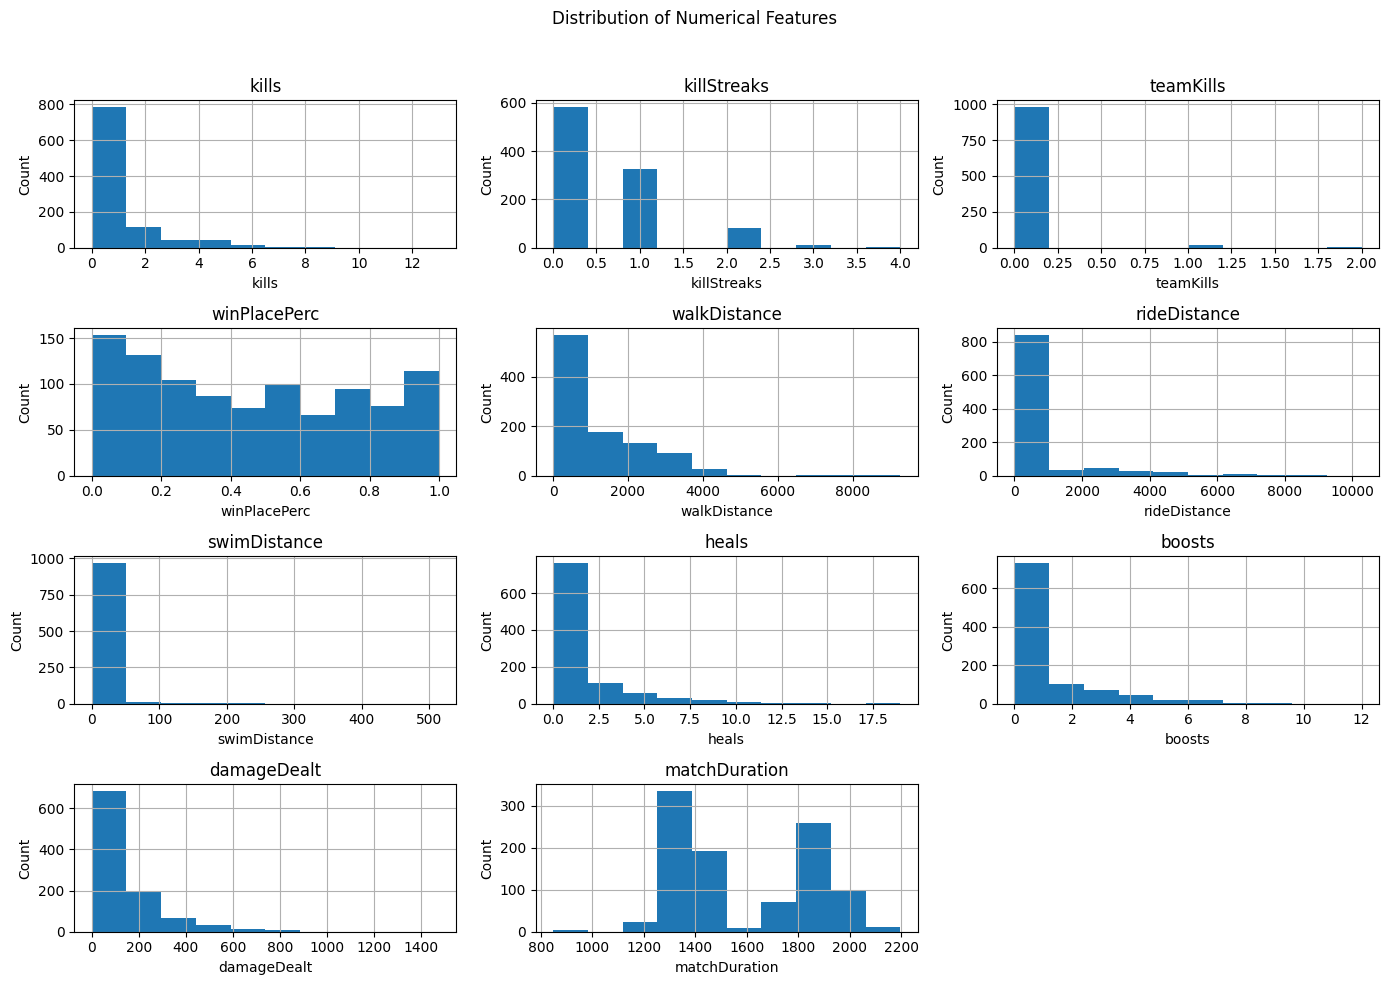

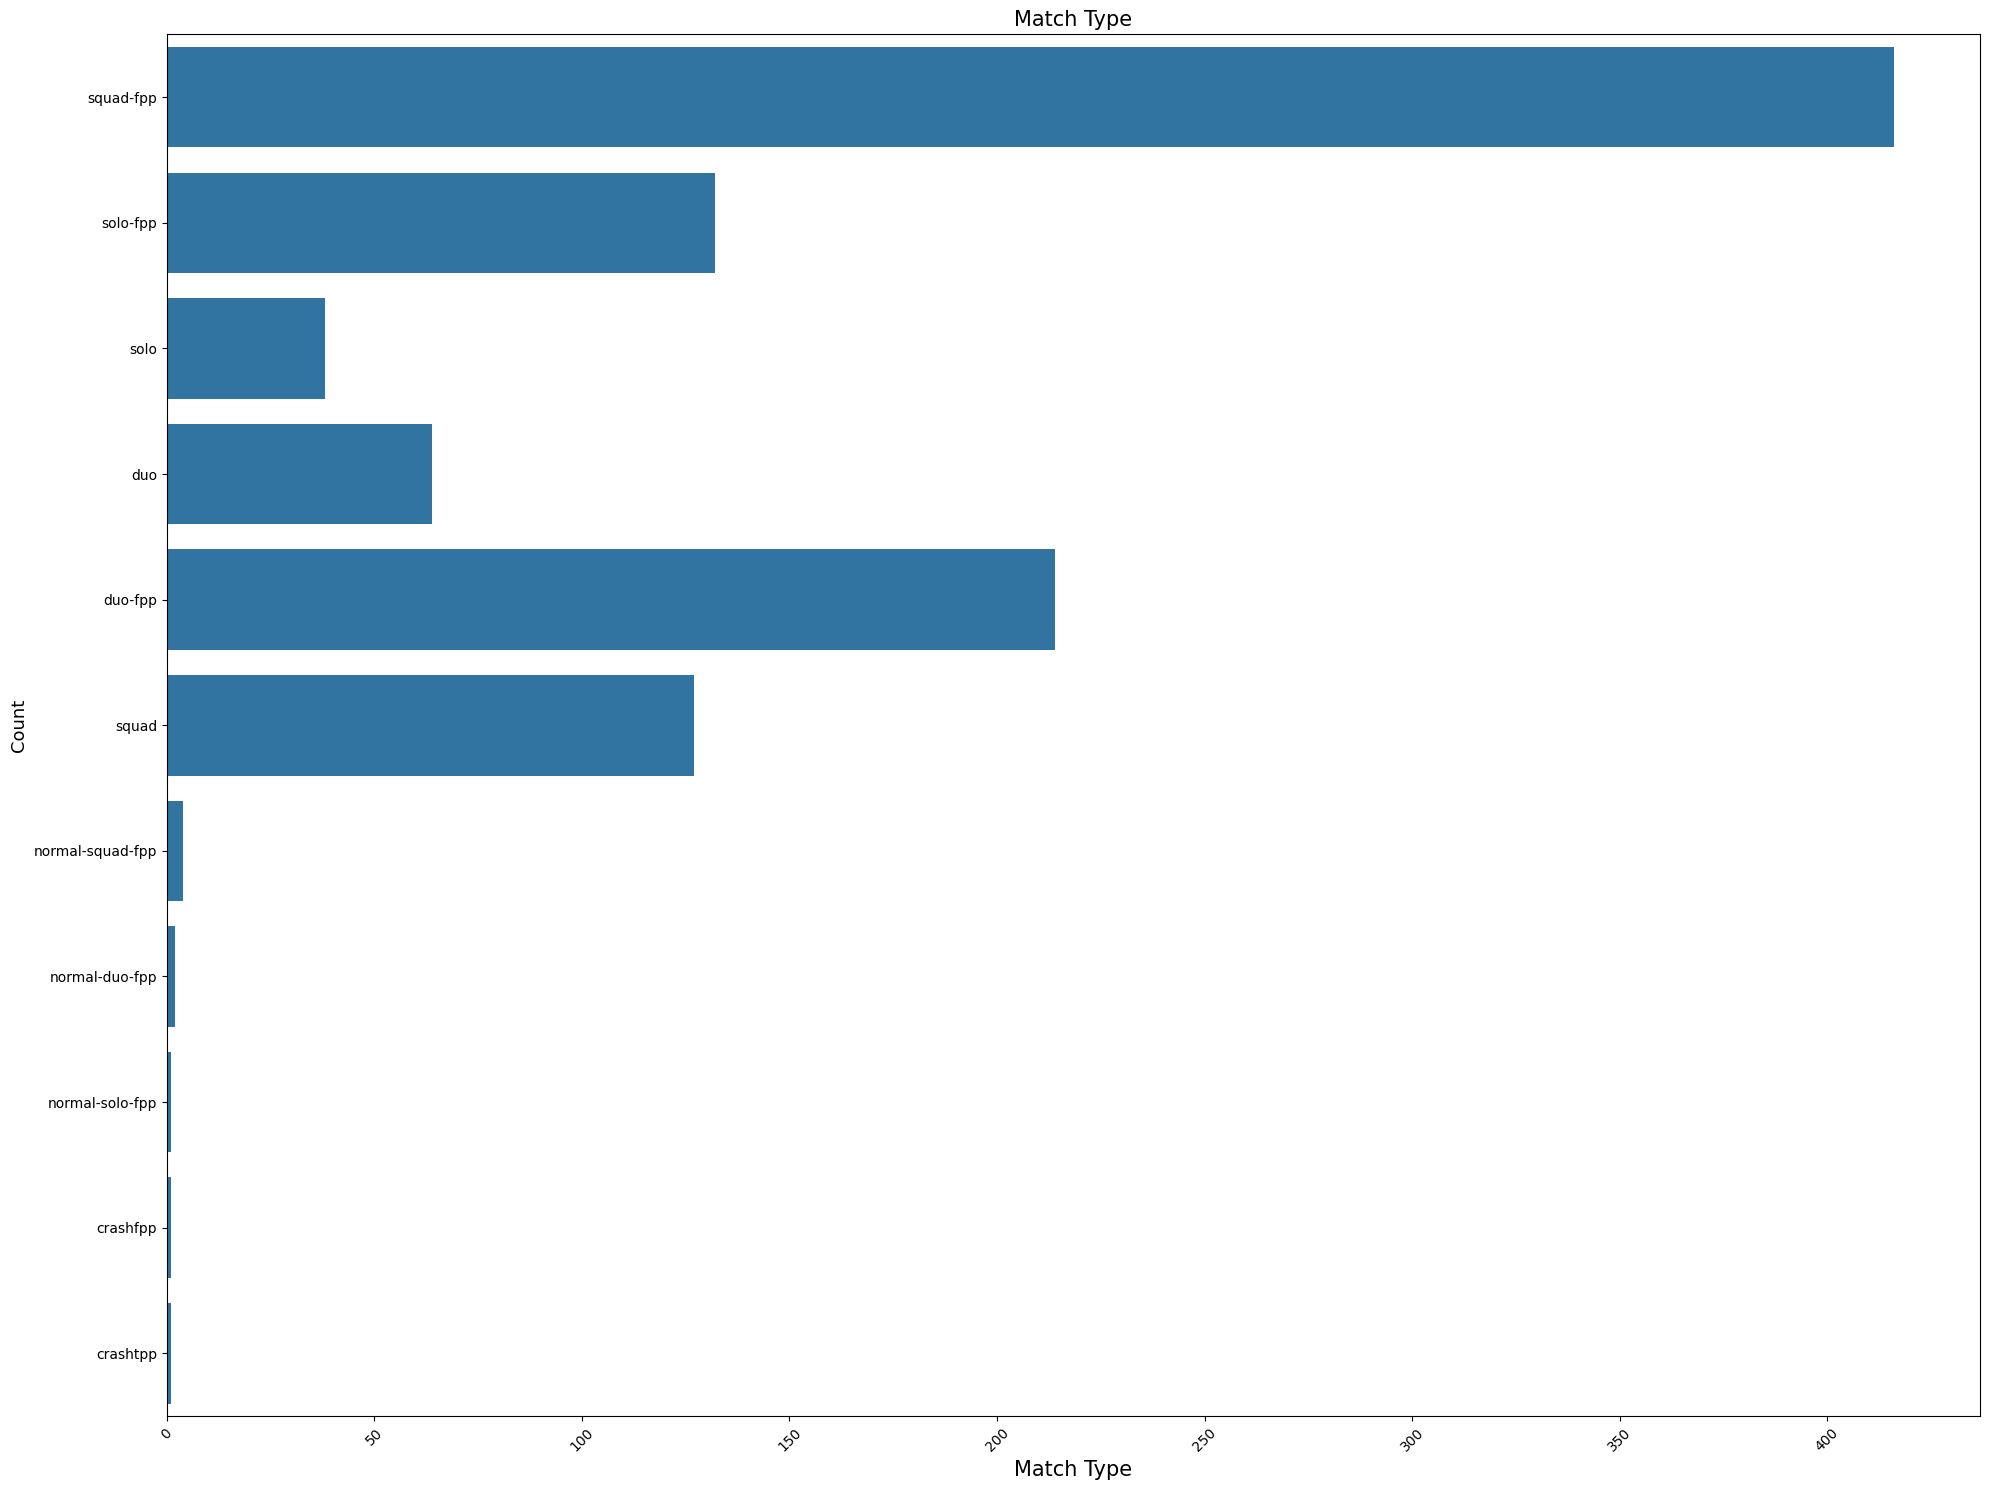

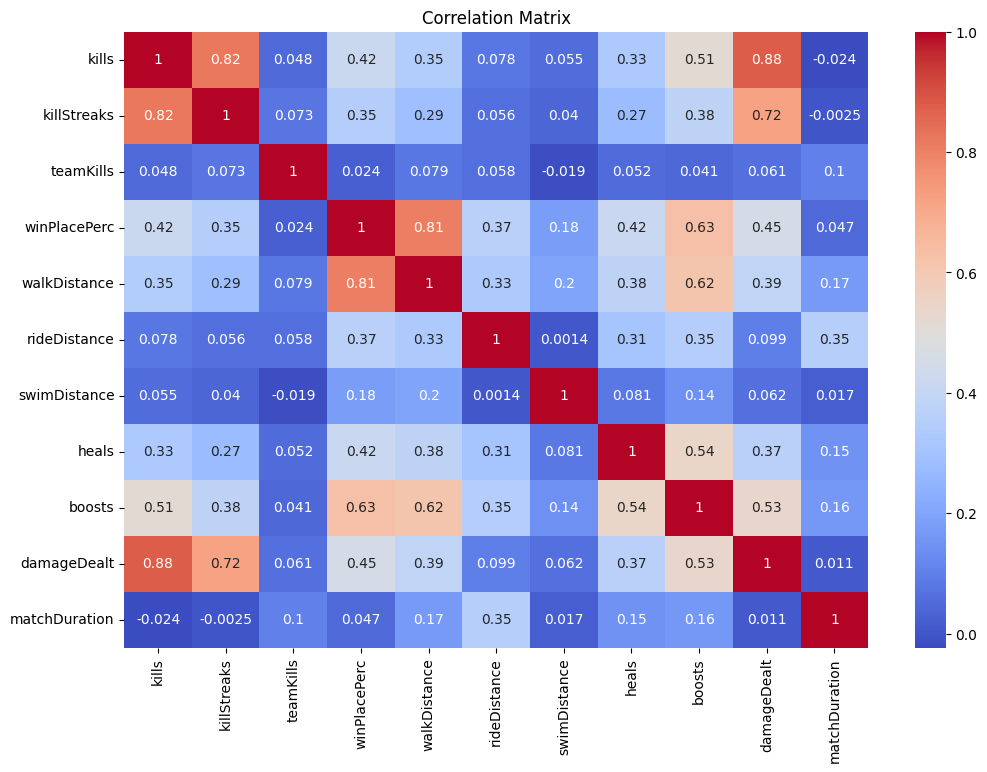

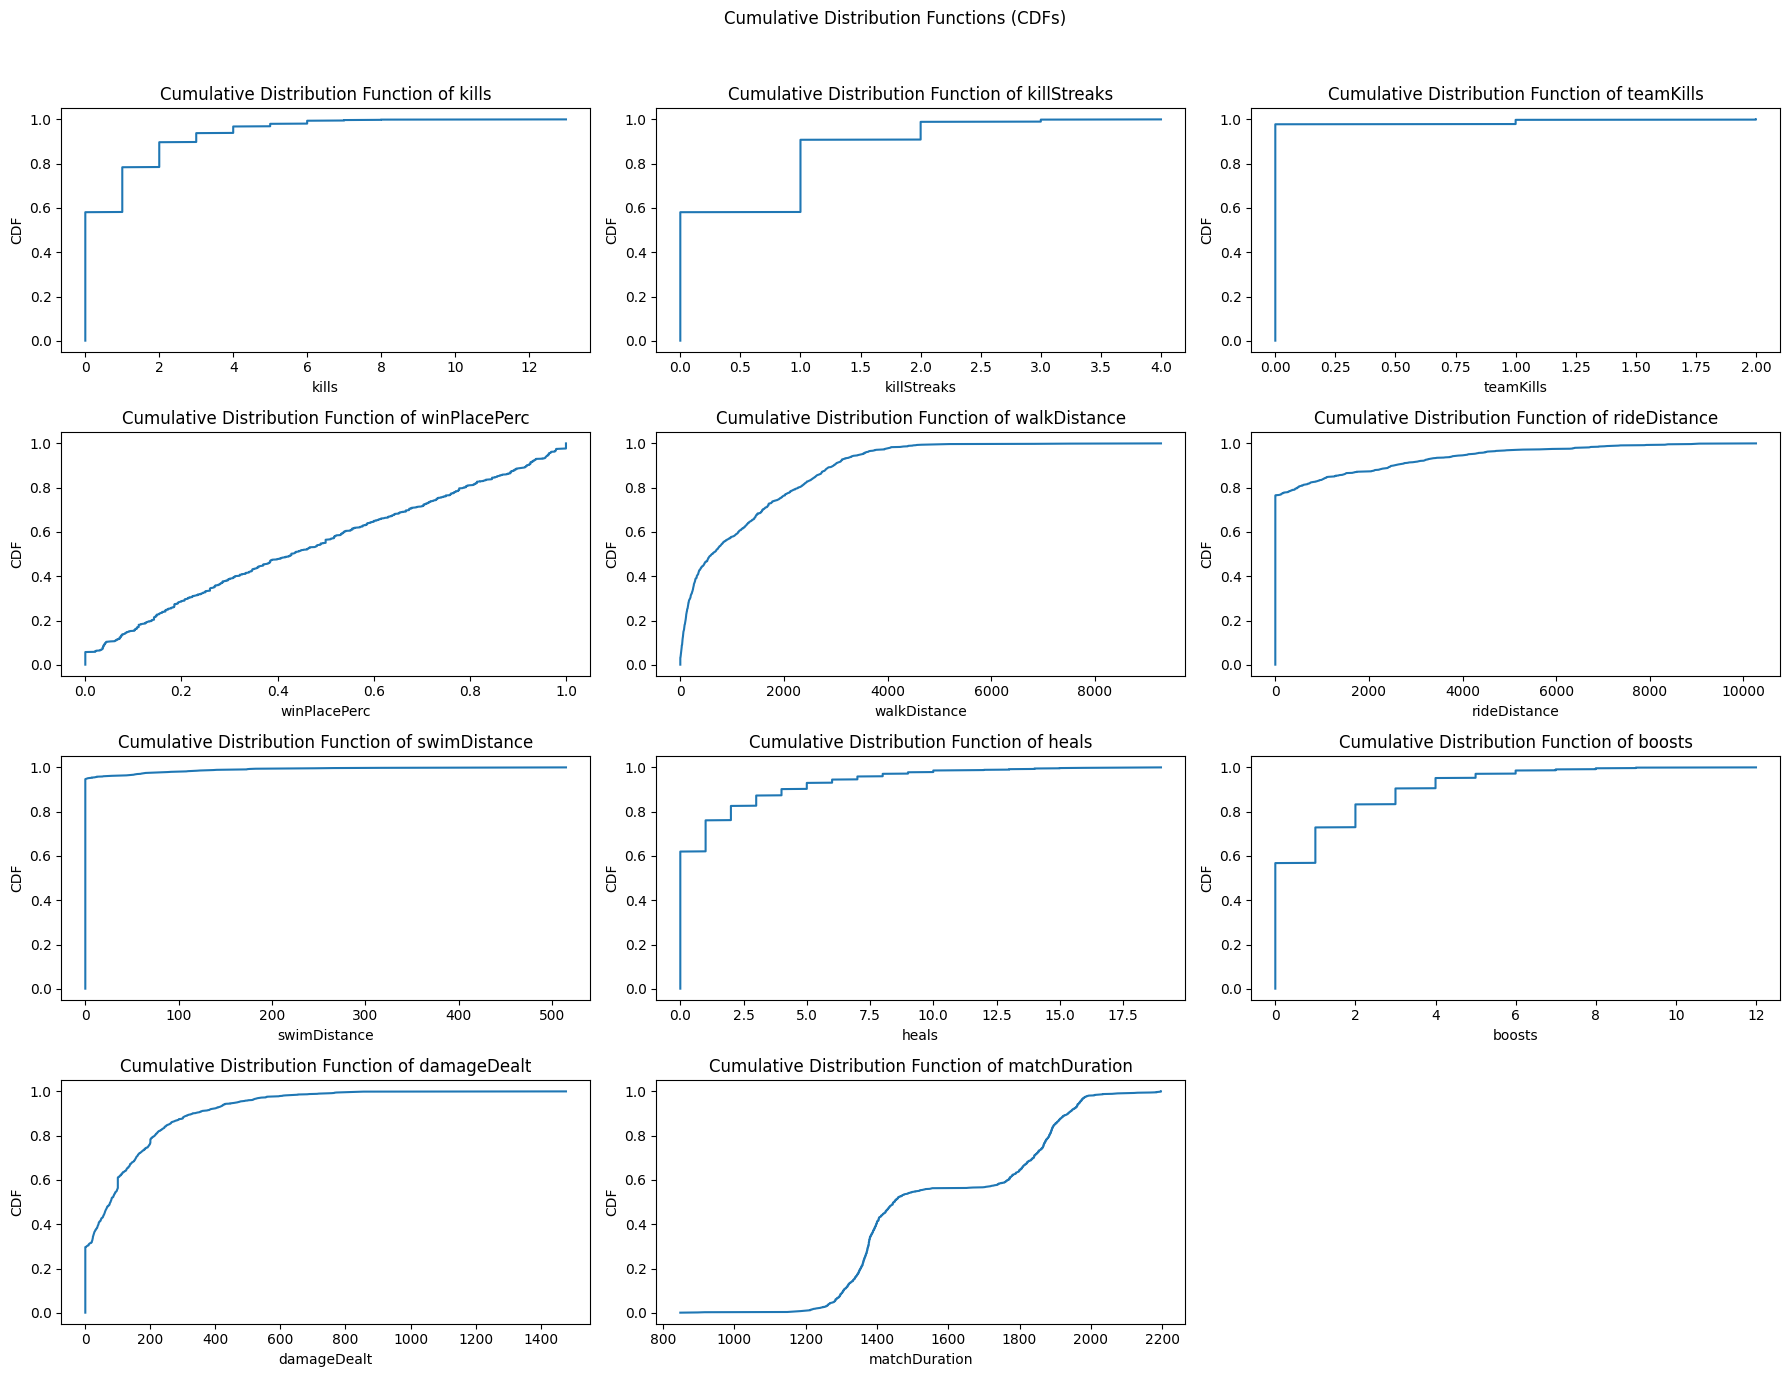

Outliers detected:
            Feature  Number of Outliers
0        Unnamed: 0                   0
1           assists                 163
2            boosts                  29
3       damageDealt                  45
4             DBNOs                  63
5     headshotKills                 156
6             heals                 174
7         killPlace                   0
8        killPoints                   0
9             kills                 103
10      killStreaks                  11
11      longestKill                 136
12    matchDuration                   0
13         maxPlace                 167
14        numGroups                 167
15       rankPoints                   0
16          revives                 137
17     rideDistance                 240
18        roadKills                   4
19     swimDistance                  54
20        teamKills                  22
21  vehicleDestroys                  12
22     walkDistance                   7
23  weaponsAcquired  

/var/folders/hw/qr7q48fs1kj7vhc9lwbs3x2h0000gn/T/ipykernel_7565/979609715.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '8+' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[data['kills'] > data['kills'].quantile(0.99), 'kills'] = '8+'


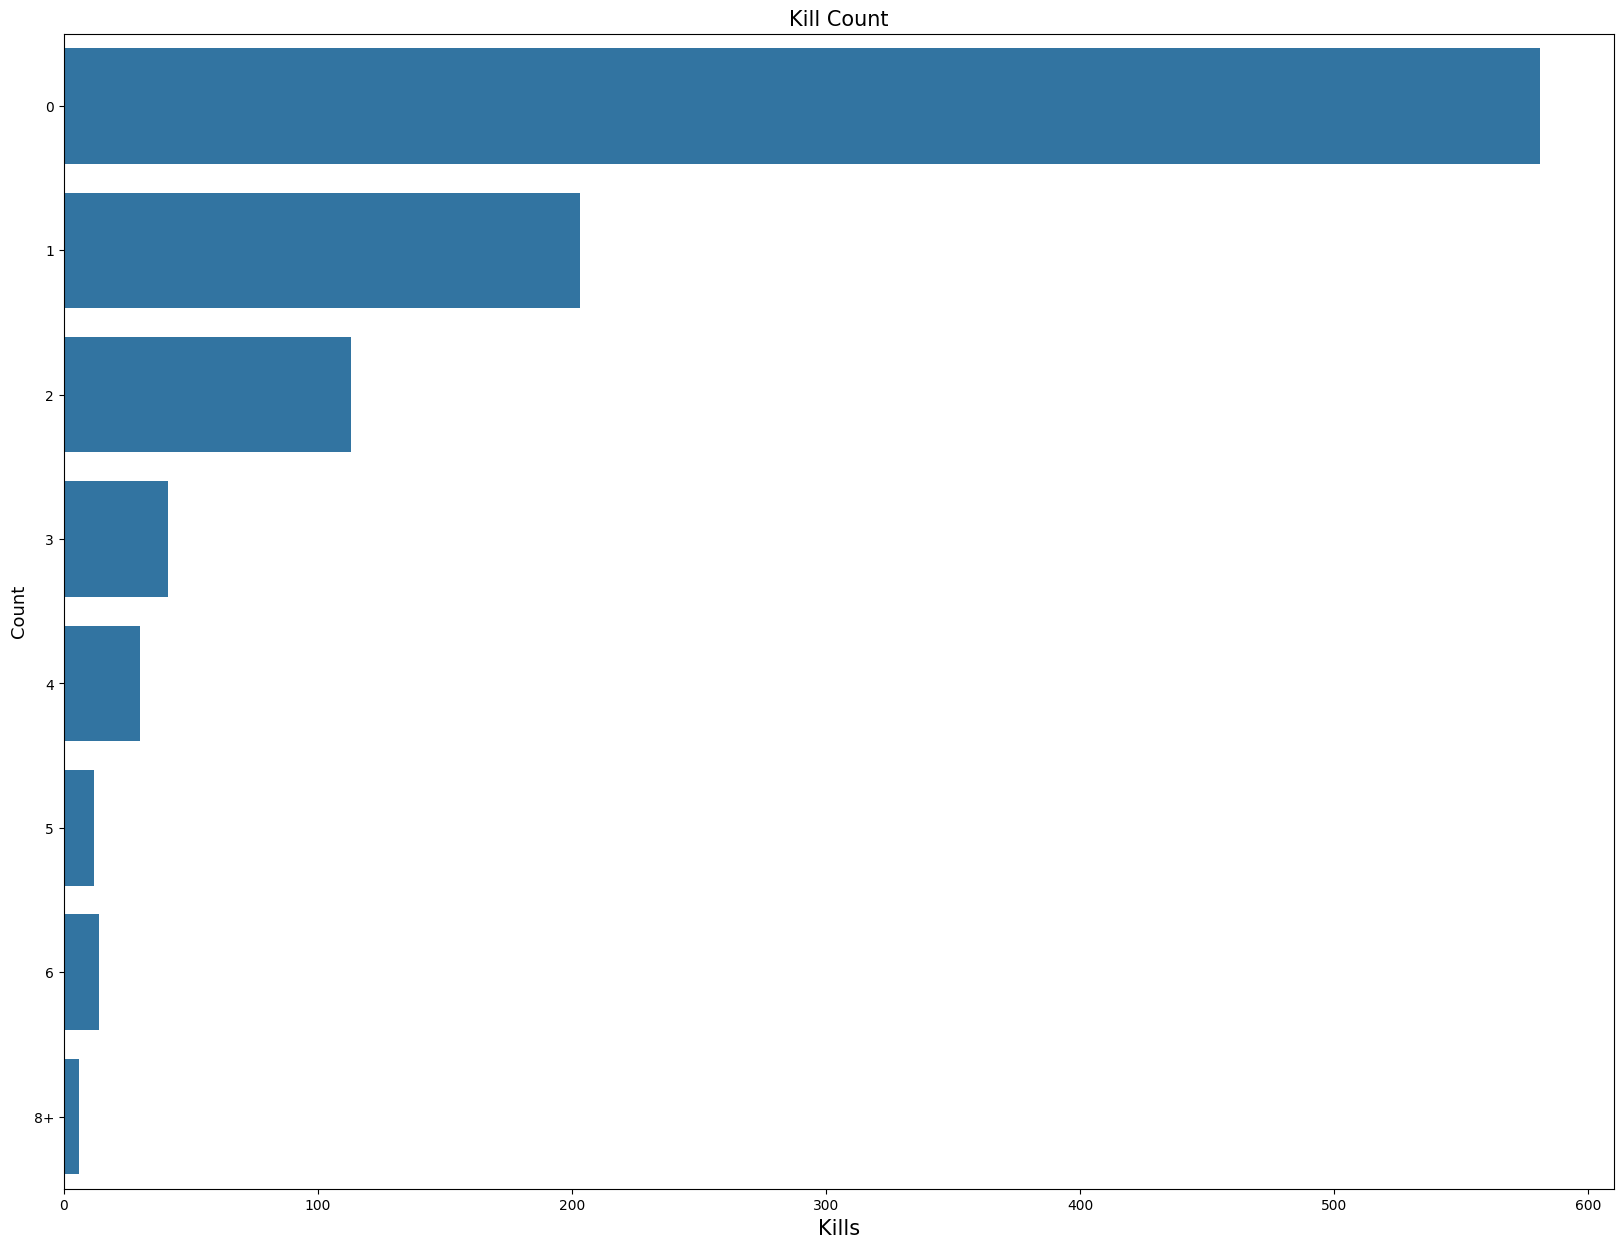

The average person kills 0.5230 players in a short time
50% of people have 0.0 kills or less in a short time
75% of people have 1.0 kills or less in a short time
99% of people have 3.0 kills or less in a short time
While the most kills in a row recorded in the data is 4


/var/folders/hw/qr7q48fs1kj7vhc9lwbs3x2h0000gn/T/ipykernel_7565/979609715.py:118: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '4+' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[data['killStreaks'] > data['killStreaks'].quantile(0.99), 'killStreaks'] = '4+'


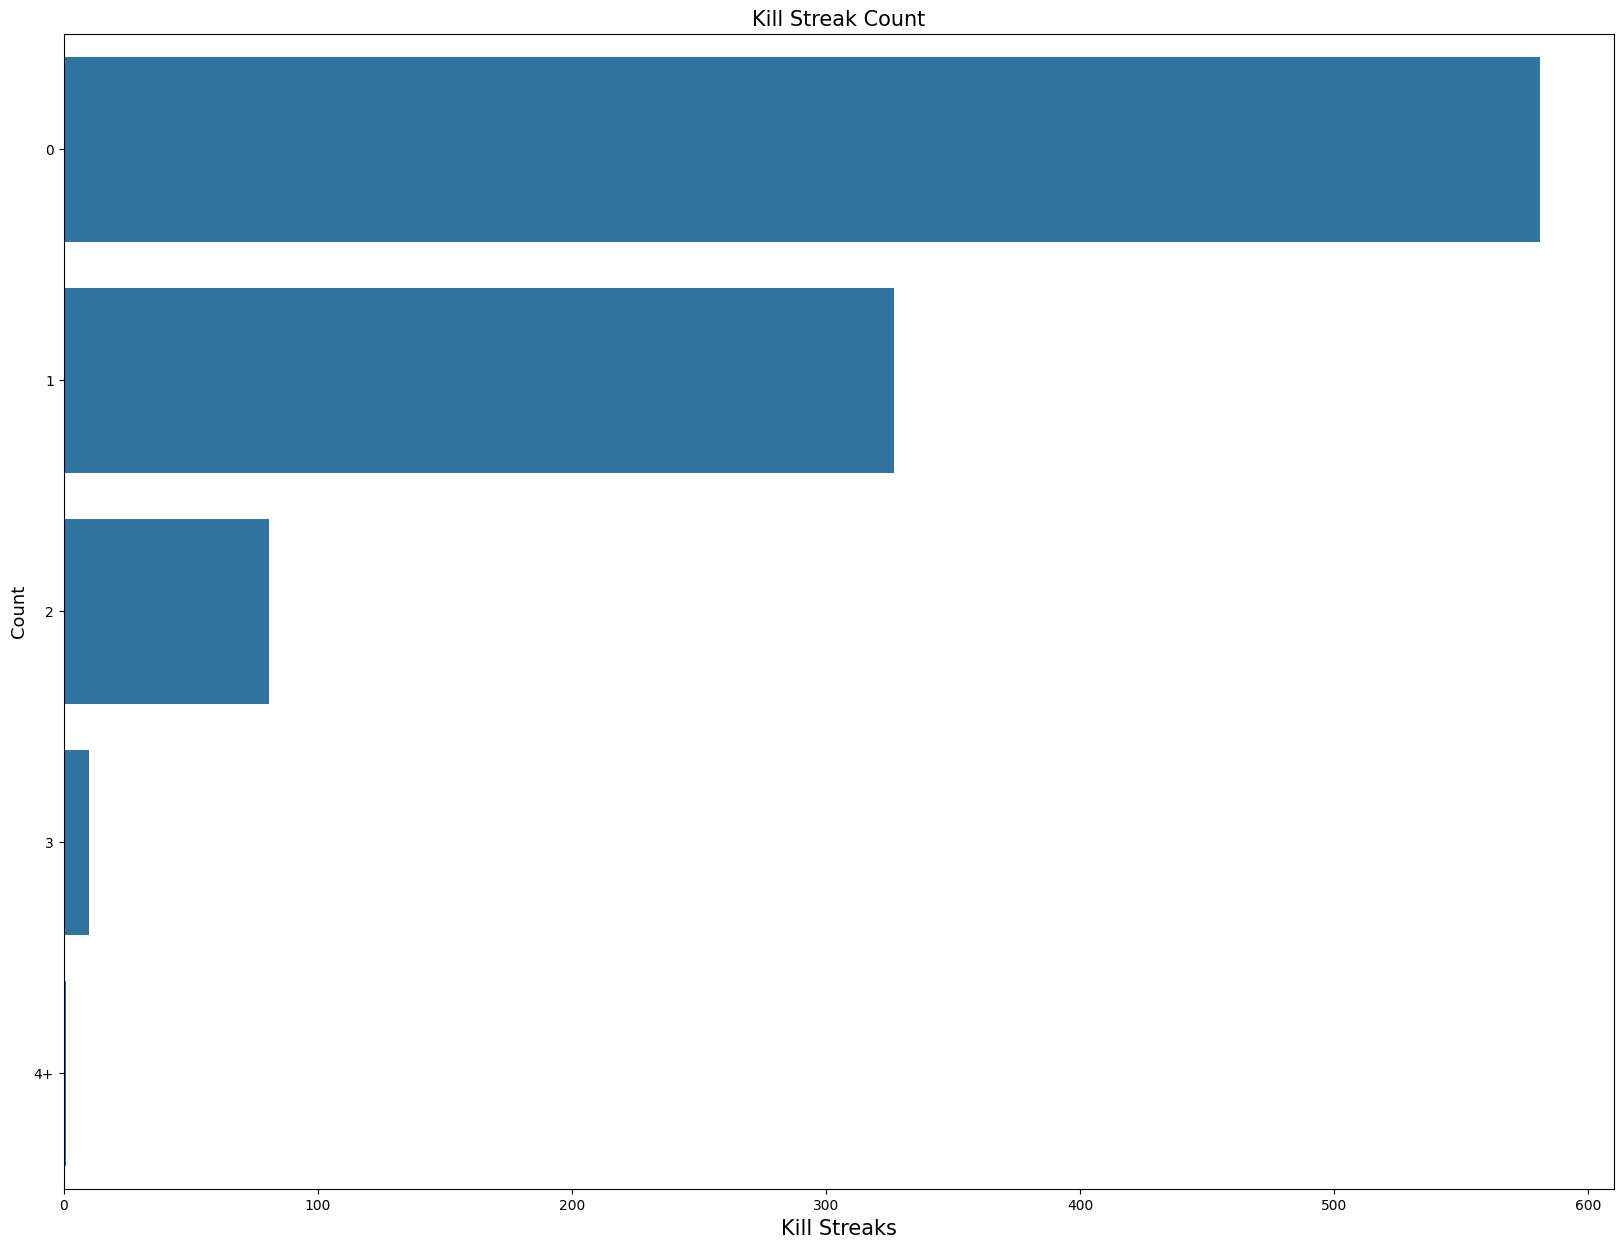

Match Types:
matchType
squad-fpp           416
duo-fpp             214
solo-fpp            132
squad               127
duo                  64
solo                 38
normal-squad-fpp      4
normal-duo-fpp        2
normal-solo-fpp       1
crashfpp              1
crashtpp              1
Name: count, dtype: int64


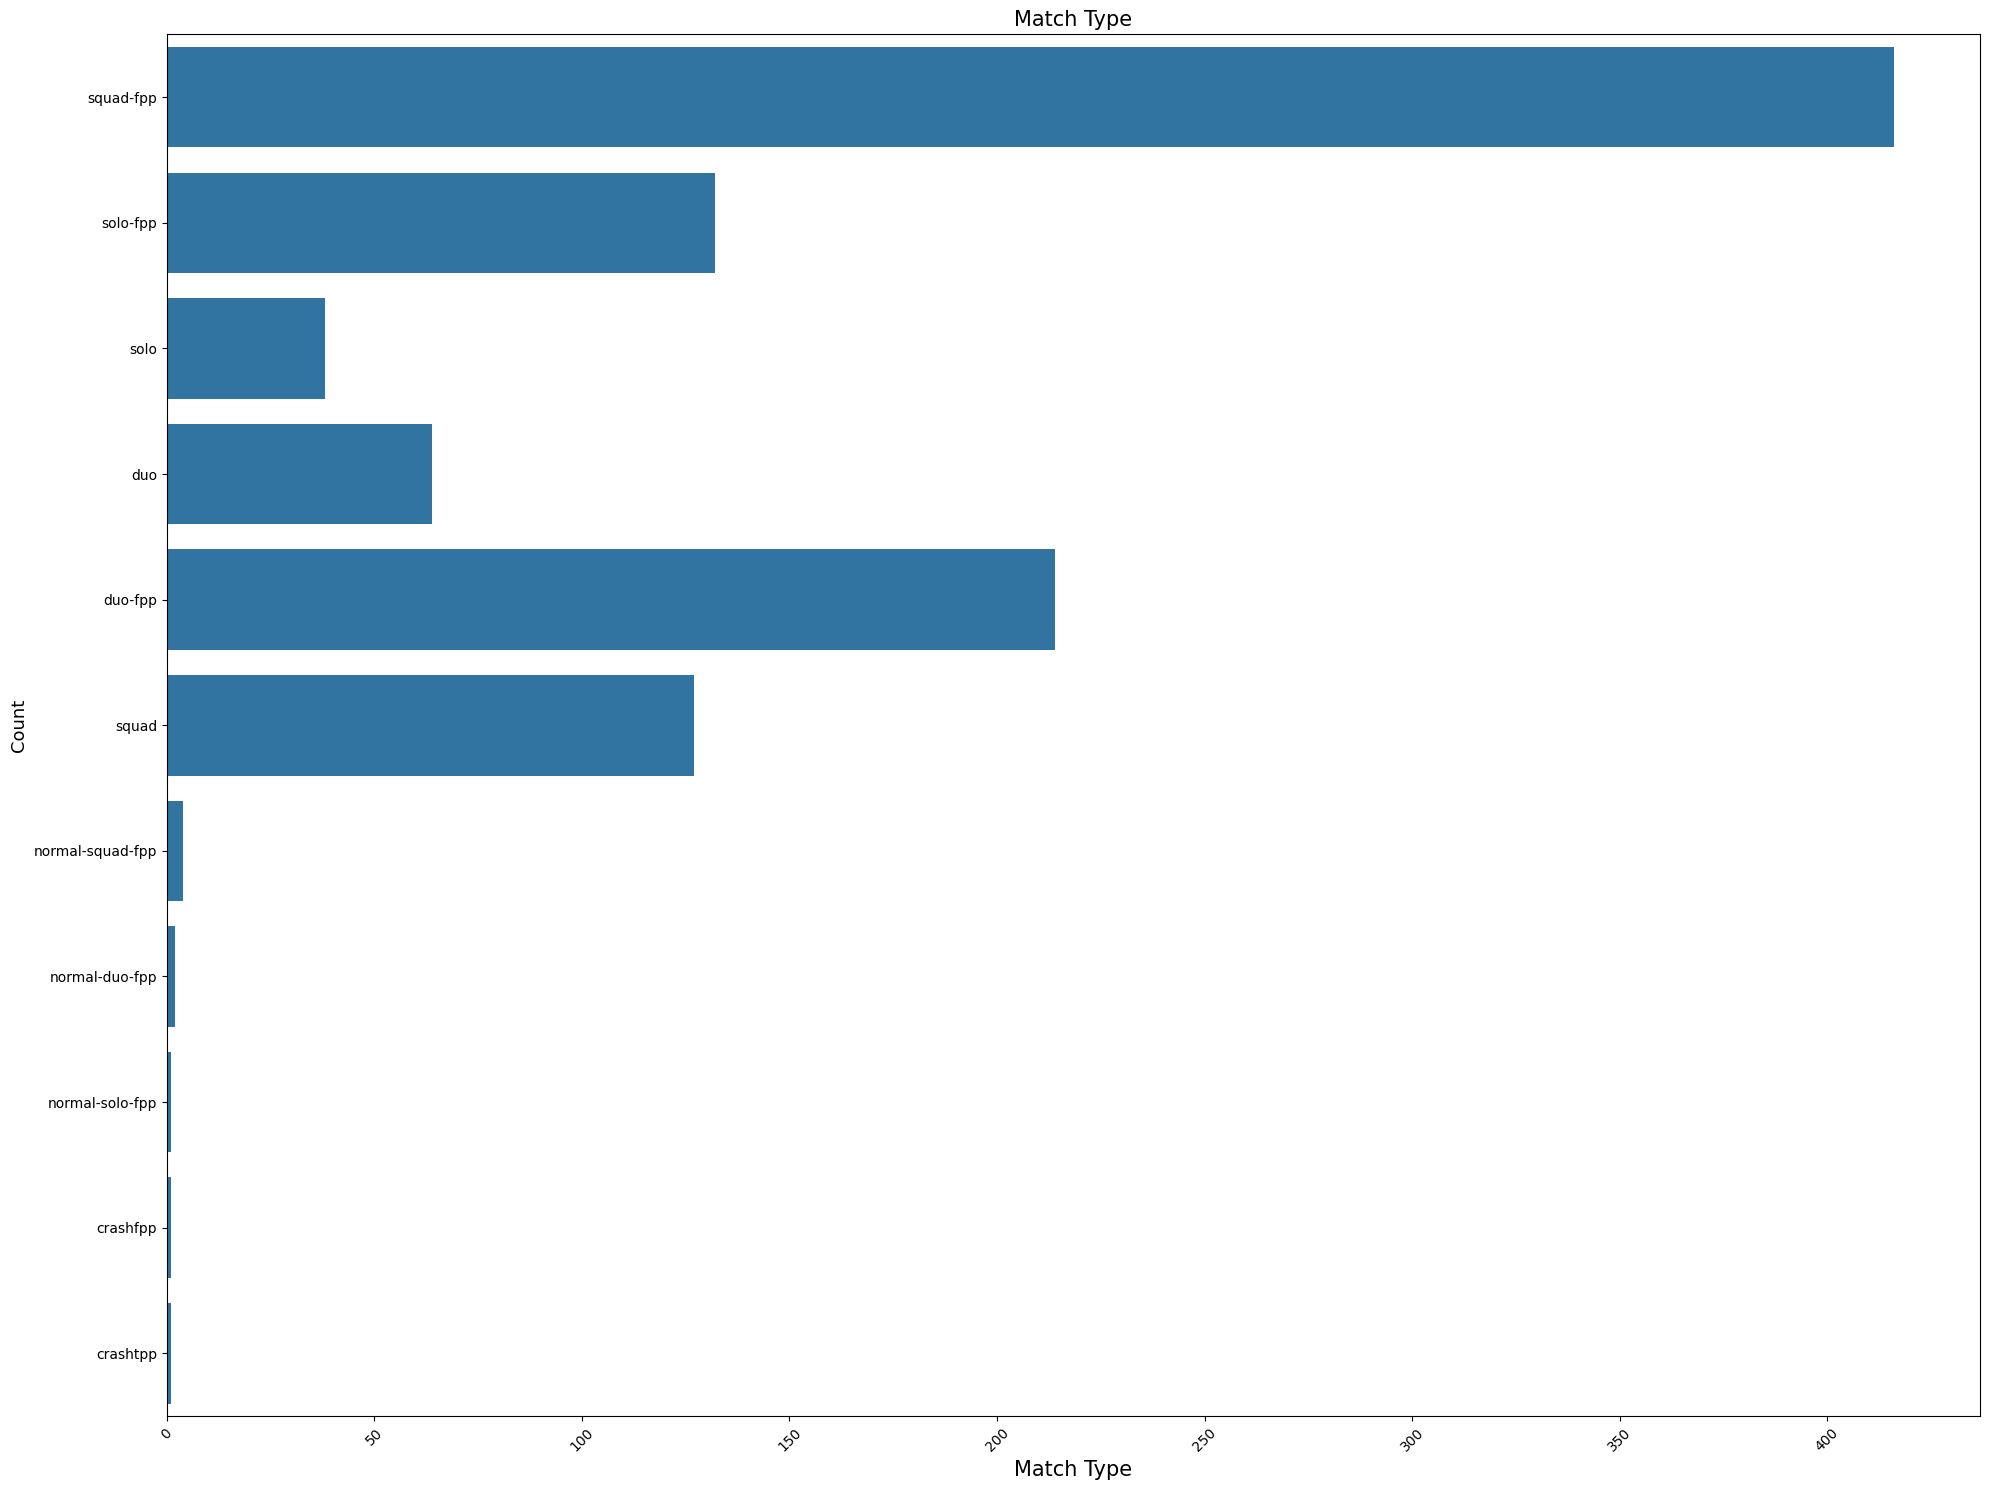

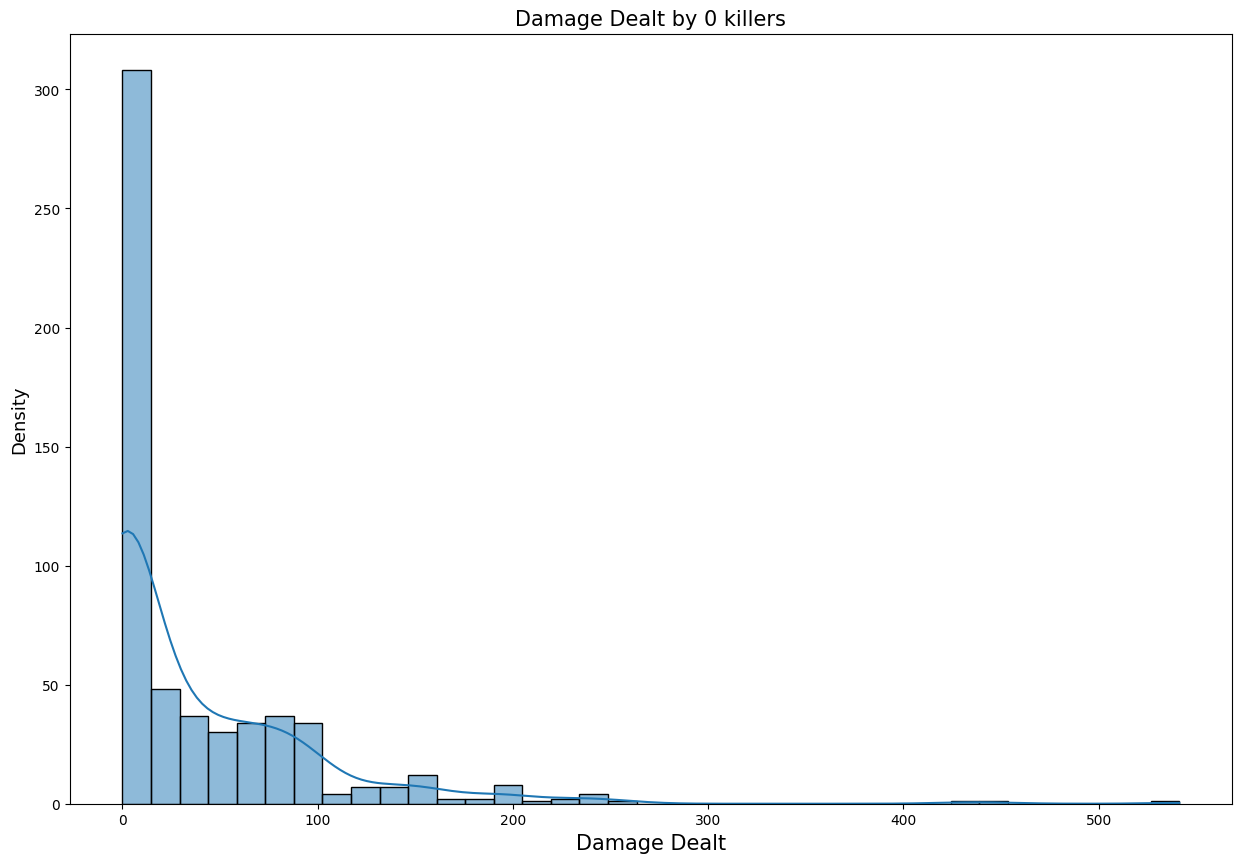

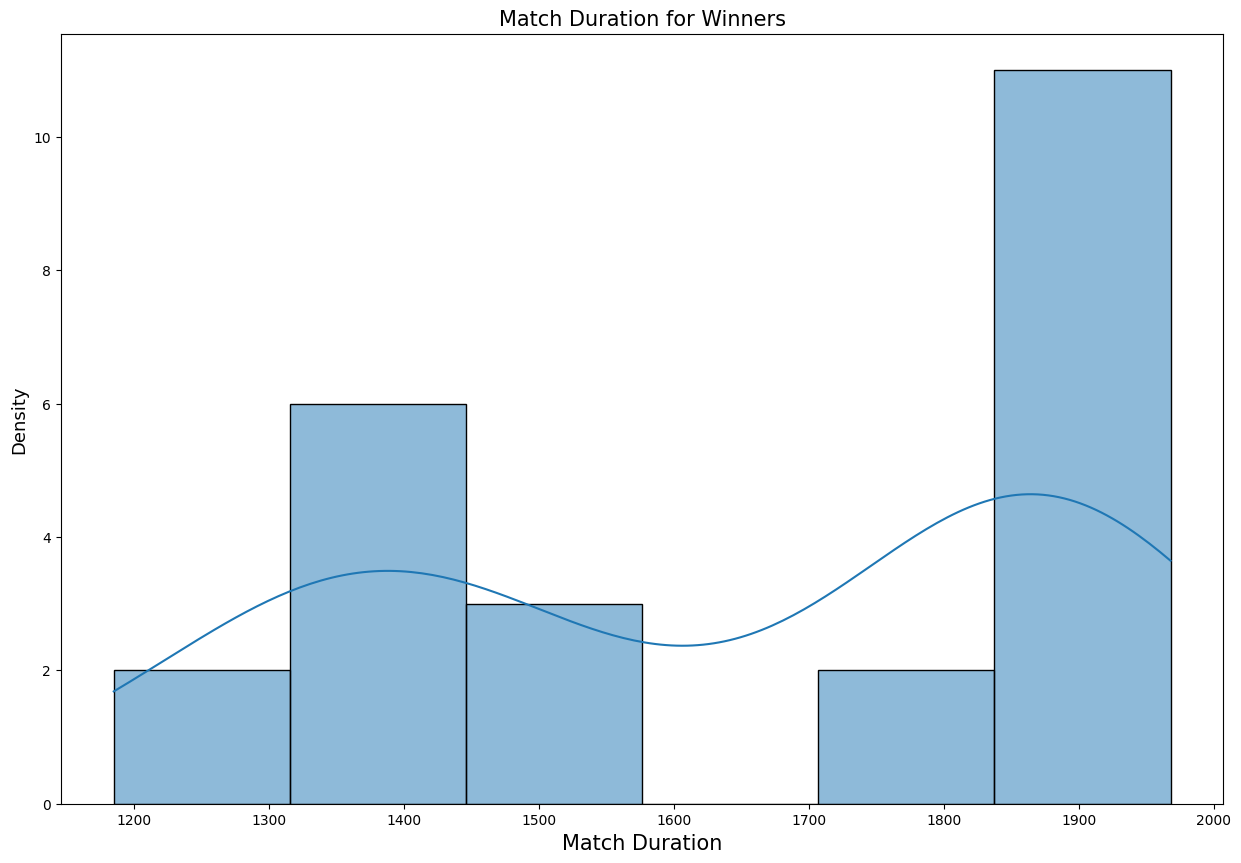

The average person kills 0.0240 players on their own team
50% of people have killed 0.0 team players
75% of people have killed 0.0 team players
99% of people have killed 1.0 team players
while the most kills recorded in the data is 2


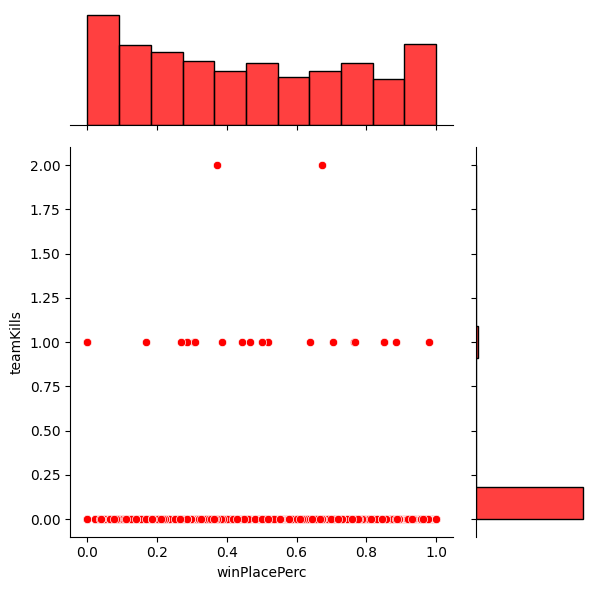

The average person travelled 1753.87 m
25% of people have travelled 140.15 m or less
50% of people have travelled 689.10 m or less
75% of people have travelled 2697.70 m or less
99% of people have travelled 10204.22 m or less
The longest distance travelled in the data is 11496.00 m


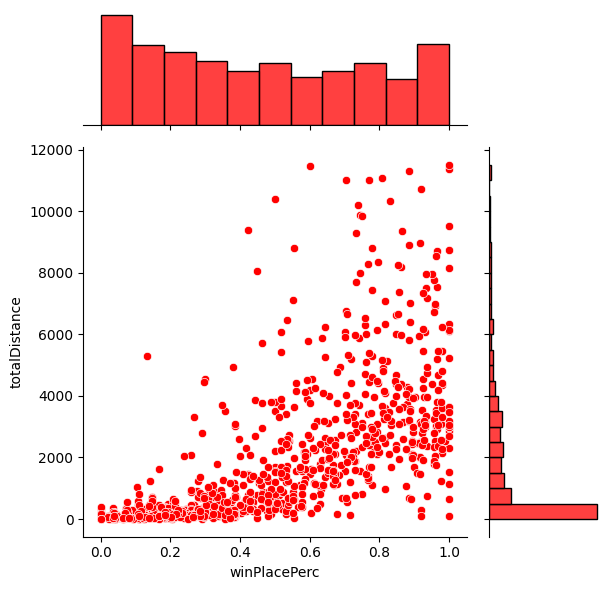

The average person uses 1.29 healing items
50% of people used 0.00 healing items
75% of people used 1.00 healing items or less
99% of people used 13.00 healing items or less
The doctor of the data used 19.00 healing items
The average person uses 1.07 boosting items
50% of people used 0.00 boosting items
75% of people used 2.00 boosting items or less
99% of people used 7.00 boosting items or less
The addict of the data used 12.00 boosting items


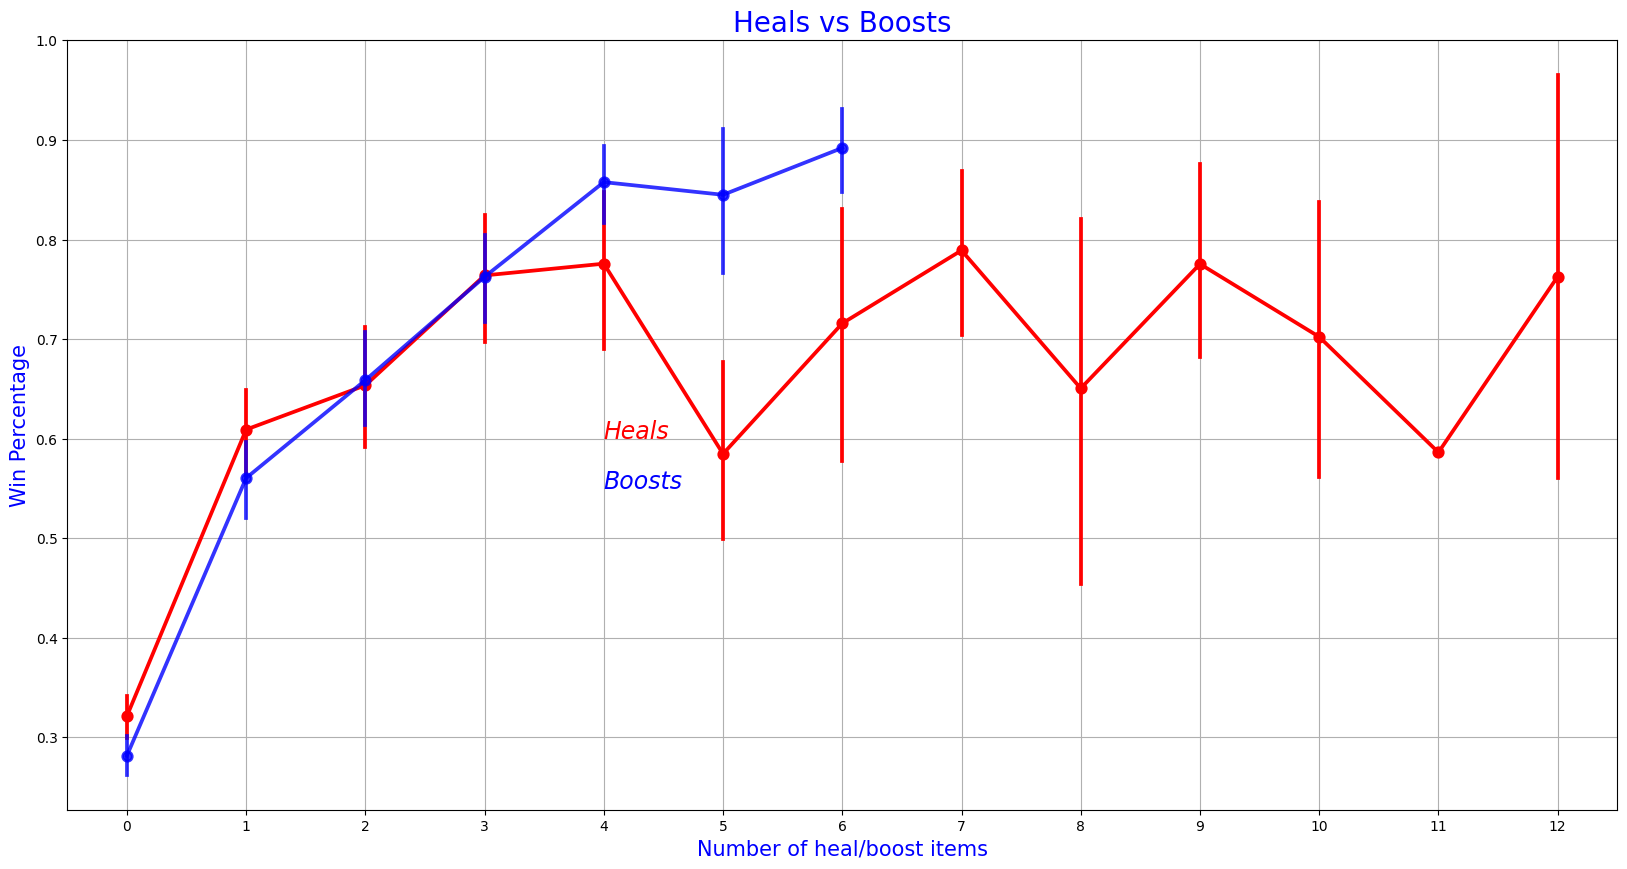

In [6]:

class PUBGDataPreprocessor:

    @staticmethod
    def eda(df: pd.DataFrame) -> None:
        warnings.filterwarnings("ignore", message="Glyph.*missing from current font", category=UserWarning)

        print("Dataset Info:")
        print(df.info())
        print("\nDataset Description:")
        print(df.describe())

        num_cols = [
            'kills', 'killStreaks', 'teamKills', 'winPlacePerc', 'walkDistance', 'rideDistance', 
            'swimDistance', 'heals', 'boosts', 'damageDealt', 'matchDuration'
        ]

        df[num_cols].hist(figsize=(14, 10), layout=(4, 3))
        plt.suptitle('Distribution of Numerical Features')
        for ax, col in zip(plt.gcf().get_axes(), num_cols):
            ax.set_xlabel(col)
            ax.set_ylabel('Count')
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

        plt.figure(figsize=(20, 15))
        sns.countplot(df['matchType'])
        plt.title('Match Type', fontsize=15)
        plt.xlabel('Match Type', fontsize=15)
        plt.ylabel('Count', fontsize=13)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        numeric_df = df[num_cols]
        corr_matrix = numeric_df.corr()
        plt.figure(figsize=(12, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
        plt.title('Correlation Matrix')
        plt.show()

        PUBGDataPreprocessor.plot_cdfs(df, num_cols)
        PUBGDataPreprocessor.detect_outliers(df)
        PUBGDataPreprocessor.summary_statistics(df)

    @staticmethod
    def plot_cdfs(df: pd.DataFrame, num_cols: List[str]) -> None:
        fig, axes = plt.subplots(4, 3, figsize=(18, 14))
        fig.suptitle('Cumulative Distribution Functions (CDFs)')

        for ax, col in zip(axes.flatten(), num_cols):
            sorted_values = np.sort(df[col])
            yvals = np.arange(1, len(sorted_values) + 1) / len(sorted_values)
            ax.plot(sorted_values, yvals)
            ax.set_title(f'Cumulative Distribution Function of {col}')
            ax.set_xlabel(col)
            ax.set_ylabel('CDF')

        for ax in axes.flatten()[len(num_cols):]:
            ax.set_visible(False)

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

    @staticmethod
    def detect_outliers(df: pd.DataFrame) -> None:
        cols = list(df)
        outliers = []
        for column in cols:
            if column in df.select_dtypes(include=np.number).columns:
                q1 = df[column].quantile(0.25)
                q3 = df[column].quantile(0.75)
                iqr = q3 - q1
                fence_low = q1 - (1.5 * iqr)
                fence_high = q3 + (1.5 * iqr)
                outliers_count = df.loc[(df[column] < fence_low) | (df[column] > fence_high)].shape[0]
                outliers.append({'Feature': column, 'Number of Outliers': outliers_count})
        outliers_df = pd.DataFrame(outliers)
        print("Outliers detected:")
        print(outliers_df)

    @staticmethod
    def summary_statistics(df: pd.DataFrame) -> None:
        PUBGDataPreprocessor.kills_statistics(df)
        PUBGDataPreprocessor.kill_streaks_statistics(df)
        PUBGDataPreprocessor.match_type_statistics(df)
        PUBGDataPreprocessor.damage_statistics(df)
        PUBGDataPreprocessor.match_duration_statistics(df)
        PUBGDataPreprocessor.team_kills_statistics(df)
        PUBGDataPreprocessor.total_distance_statistics(df)
        PUBGDataPreprocessor.healing_boosting_statistics(df)

    @staticmethod
    def kills_statistics(df: pd.DataFrame) -> None:
        print('The average person kills {:.4f} players'.format(df['kills'].mean()))
        print('50% of people have', df['kills'].quantile(0.50), 'kills or less')
        print('75% of people have', df['kills'].quantile(0.75), 'kills or less')
        print('99% of people have', df['kills'].quantile(0.99), 'kills or less')
        print('while the most kills recorded in the data is', df['kills'].max())

        data = df.copy()
        data.loc[data['kills'] > data['kills'].quantile(0.99), 'kills'] = '8+'
        plt.figure(figsize=(20, 15))
        sns.countplot(data['kills'].astype(str).sort_values())
        plt.title('Kill Count', fontsize=15)
        plt.xlabel('Kills', fontsize=15)
        plt.ylabel('Count', fontsize=13)
        plt.show()

    @staticmethod
    def kill_streaks_statistics(df: pd.DataFrame) -> None:
        print('The average person kills {:.4f} players in a short time'.format(df['killStreaks'].mean()))
        print('50% of people have', df['killStreaks'].quantile(0.50), 'kills or less in a short time')
        print('75% of people have', df['killStreaks'].quantile(0.75), 'kills or less in a short time')
        print('99% of people have', df['killStreaks'].quantile(0.99), 'kills or less in a short time')
        print('While the most kills in a row recorded in the data is', df['killStreaks'].max())

        data = df.copy()
        data.loc[data['killStreaks'] > data['killStreaks'].quantile(0.99), 'killStreaks'] = '4+'
        plt.figure(figsize=(20, 15))
        sns.countplot(data['killStreaks'].astype(str).sort_values())
        plt.title('Kill Streak Count', fontsize=15)
        plt.xlabel('Kill Streaks', fontsize=15)
        plt.ylabel('Count', fontsize=13)
        plt.show()

    @staticmethod
    def match_type_statistics(df: pd.DataFrame) -> None:
        print('Match Types:')
        print(df['matchType'].value_counts())

        plt.figure(figsize=(20, 15))
        sns.countplot(df['matchType'])
        plt.title('Match Type', fontsize=15)
        plt.xlabel('Match Type', fontsize=15)
        plt.ylabel('Count', fontsize=13)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    @staticmethod
    def damage_statistics(df: pd.DataFrame) -> None:
        data = df[df['kills'] == 0]
        plt.figure(figsize=(15, 10))
        plt.title('Damage Dealt by 0 killers', fontsize=15)
        sns.histplot(data['damageDealt'], kde=True)
        plt.xlabel('Damage Dealt', fontsize=15)
        plt.ylabel('Density', fontsize=13)
        plt.show()

    @staticmethod
    def match_duration_statistics(df: pd.DataFrame) -> None:
        data = df[df['winPlacePerc'] == 1]
        plt.figure(figsize=(15, 10))
        plt.title('Match Duration for Winners', fontsize=15)
        sns.histplot(data['matchDuration'], kde=True)
        plt.xlabel('Match Duration', fontsize=15)
        plt.ylabel('Density', fontsize=13)
        plt.show()

    @staticmethod
    def team_kills_statistics(df: pd.DataFrame) -> None:
        print('The average person kills {:.4f} players on their own team'.format(df['teamKills'].mean()))
        print('50% of people have killed', df['teamKills'].quantile(0.50), 'team players')
        print('75% of people have killed', df['teamKills'].quantile(0.75), 'team players')
        print('99% of people have killed', df['teamKills'].quantile(0.99), 'team players')
        print('while the most kills recorded in the data is', df['teamKills'].max())

        sns.jointplot(x='winPlacePerc', y='teamKills', data=df, ratio=3, color='r')
        plt.show()

    @staticmethod
    def total_distance_statistics(df: pd.DataFrame) -> None:
        df['totalDistance'] = df['walkDistance'] + df['rideDistance'] + df['swimDistance']
        print('The average person travelled {:.2f} m'.format(df['totalDistance'].mean()))
        print('25% of people have travelled {:.2f} m or less'.format(df['totalDistance'].quantile(0.25)))
        print('50% of people have travelled {:.2f} m or less'.format(df['totalDistance'].quantile(0.50)))
        print('75% of people have travelled {:.2f} m or less'.format(df['totalDistance'].quantile(0.75)))
        print('99% of people have travelled {:.2f} m or less'.format(df['totalDistance'].quantile(0.99)))
        print('The longest distance travelled in the data is {:.2f} m'.format(df['totalDistance'].max()))

        sns.jointplot(x='winPlacePerc', y='totalDistance', data=df, ratio=3, color='r')
        plt.show()

    @staticmethod
    def healing_boosting_statistics(df: pd.DataFrame) -> None:
        print('The average person uses {:.2f} healing items'.format(df['heals'].mean()))
        print('50% of people used {:.2f} healing items'.format(df['heals'].quantile(0.50)))
        print('75% of people used {:.2f} healing items or less'.format(df['heals'].quantile(0.75)))
        print('99% of people used {:.2f} healing items or less'.format(df['heals'].quantile(0.99)))
        print('The doctor of the data used {:.2f} healing items'.format(df['heals'].max()))

        print('The average person uses {:.2f} boosting items'.format(df['boosts'].mean()))
        print('50% of people used {:.2f} boosting items'.format(df['boosts'].quantile(0.50)))
        print('75% of people used {:.2f} boosting items or less'.format(df['boosts'].quantile(0.75)))
        print('99% of people used {:.2f} boosting items or less'.format(df['boosts'].quantile(0.99)))
        print('The addict of the data used {:.2f} boosting items'.format(df['boosts'].max()))

        data = df.copy()
        data = data[data['heals'] < data['heals'].quantile(0.99)]
        data = data[data['boosts'] < data['boosts'].quantile(0.99)]

        f, ax1 = plt.subplots(figsize=(20, 10))
        sns.pointplot(x='heals', y='winPlacePerc', data=data, color='red', alpha=1.0)
        sns.pointplot(x='boosts', y='winPlacePerc', data=data, color='blue', alpha=0.8)
        plt.text(4, 0.6, 'Heals', color='red', fontsize=17, style='italic')
        plt.text(4, 0.55, 'Boosts', color='blue', fontsize=17, style='italic')
        plt.xlabel('Number of heal/boost items', fontsize=15, color='blue')
        plt.ylabel('Win Percentage', fontsize=15, color='blue')
        plt.title('Heals vs Boosts', fontsize=20, color='blue')
        plt.grid()
        plt.show()

# Example usage:
df = pd.read_csv('data.csv')
PUBGDataPreprocessor.eda(df)


# PubgDataPreprocessor Class

This document outlines the functions and methods used in the PubgDataPreprocessor class.

## Methods

- `__init__`: Initializes the PubgDataPreprocessor class with the provided DataFrame.
- `fill_missing_values`: Fills missing values in the DataFrame by calling the internal method `_fill_numerical_missing_values`.
- `_fill_numerical_missing_values`: Fills missing values in numerical columns with their respective mean values.
- `convert_dtypes`: Converts the data type of the 'matchType' column to 'category'.
- `one_hot_encode_categorical`: One-hot encodes the categorical columns and returns the resulting DataFrame.
- `normalize_numerical`: Normalizes numerical columns using the StandardScaler and returns the scaled DataFrame.
- `extract_game_vectors`: Extracts game vectors from the DataFrame by applying the internal method `_create_game_vector`.
- `_create_game_vector`: Creates a game vector for a row in the DataFrame.
- `extract_aggregate_vector`: Extracts aggregate vectors from the DataFrame by applying the internal method `_create_aggregate_vector`.
- `_create_aggregate_vector`: Creates an aggregate vector for a row in the DataFrame.
- `combine_features`: Combines the encoded categorical features, scaled numerical features, game vectors, and aggregate vectors into the DataFrame. Drops the 'matchType' column and other specified columns.
- `preprocess`: Runs the complete preprocessing pipeline by calling the appropriate methods and returns the processed DataFrame.


In [2]:
class PubgDataPreprocessor:
    def __init__(self, dataframe: pd.DataFrame):
        self.df = dataframe

    def fill_missing_values(self) -> None:
        self._fill_numerical_missing_values()

    def _fill_numerical_missing_values(self) -> None:
        num_cols = ['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals', 'killPlace', 
                    'killPoints', 'kills', 'killStreaks', 'longestKill', 'matchDuration', 'rideDistance', 
                    'roadKills', 'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 
                    'winPoints', 'winPlacePerc']
        self.df[num_cols] = self.df[num_cols].fillna(self.df[num_cols].mean())

    def convert_dtypes(self) -> None:
        self.df['matchType'] = self.df['matchType'].astype('category')

    def one_hot_encode_categorical(self) -> pd.DataFrame:
        categorical_cols = ['matchType']
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        encoded_cats = encoder.fit_transform(self.df[categorical_cols])
        encoded_cats_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(categorical_cols))
        return encoded_cats_df

    def normalize_numerical(self) -> pd.DataFrame:
        numerical_cols = ['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals', 'killPlace', 
                          'killPoints', 'kills', 'killStreaks', 'longestKill', 'matchDuration', 'rideDistance', 
                          'roadKills', 'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance', 
                          'weaponsAcquired', 'winPoints', 'winPlacePerc']
        scaler = StandardScaler()
        scaled_nums = scaler.fit_transform(self.df[numerical_cols])
        self.df[numerical_cols] = scaled_nums  # Update the DataFrame with the scaled values
        return pd.DataFrame(scaled_nums, columns=numerical_cols)

    def extract_game_vectors(self) -> pd.DataFrame:
        game_vectors = self.df.apply(self._create_game_vector, axis=1)
        return game_vectors

    def _create_game_vector(self, row) -> List:
        return [
            row['assists'],
            row['boosts'],
            row['damageDealt'],
            row['DBNOs'],
            row['headshotKills'],
            row['heals'],
            row['killPlace'],
            row['killPoints'],
            row['kills'],
            row['killStreaks'],
            row['longestKill'],
            row['matchDuration'],
            row['rideDistance'],
            row['roadKills'],
            row['swimDistance'],
            row['teamKills'],
            row['vehicleDestroys'],
            row['walkDistance'],
            row['weaponsAcquired'],
            row['winPoints']
        ]

    def extract_aggregate_vector(self) -> pd.DataFrame:
        aggregate_vectors = self.df.apply(self._create_aggregate_vector, axis=1)
        return aggregate_vectors

    def _create_aggregate_vector(self, row) -> List:
        return [
            row['kills'],
            row['damageDealt'],
            row['walkDistance'],
            row['rideDistance'],
            row['boosts'],
            row['heals'],
            row['killPlace']
        ]

    def combine_features(self, encoded_cats_df: pd.DataFrame, scaled_nums_df: pd.DataFrame, game_vectors: pd.DataFrame, aggregate_vectors: pd.DataFrame) -> None:
        self.df.drop(columns=['matchType'], inplace=True)
        self.df = pd.concat([self.df, encoded_cats_df, scaled_nums_df], axis=1)
        self.df['game_vector'] = game_vectors
        self.df['aggregate_vector'] = aggregate_vectors
        drop_columns = ['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals', 'killPlace', 
                        'killPoints', 'kills', 'killStreaks', 'longestKill', 'matchDuration', 'rideDistance', 
                        'roadKills', 'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance', 
                        'weaponsAcquired', 'winPoints', 'winPlacePerc']
        self.df.drop(columns=drop_columns, inplace=True)

    def preprocess(self) -> pd.DataFrame:
        self.fill_missing_values()
        self.convert_dtypes()
        encoded_cats_df = self.one_hot_encode_categorical()
        scaled_nums_df = self.normalize_numerical()
        game_vectors = self.extract_game_vectors()
        aggregate_vectors = self.extract_aggregate_vector()
        self.combine_features(encoded_cats_df, scaled_nums_df, game_vectors, aggregate_vectors)
        self.df = self.df.loc[:, ~self.df.columns.duplicated()]
        return self.df


In [61]:
df = pd.read_csv('data.csv')
preprocessor = PubgDataPreprocessor(df)
preprocessed_df = preprocessor.preprocess()
preprocessed_df.to_csv('preprocessed_output_pubg_dataset.csv', index=False)

# PubgRecommendationSystem Class

This document outlines the functions and methods used in the PubgRecommendationSystem class.

## Methods

- `__init__`: Initializes the PubgRecommendationSystem class with the provided weights and other attributes.
- `fit_knn`: Fits the k-Nearest Neighbors (kNN) model using the preprocessed data loaded from a CSV file.
- `prepare_expanded_df`: Prepares the expanded DataFrame by dropping unnecessary columns.
- `normalize_expanded_df`: Normalizes numerical features in the expanded DataFrame.
- `apply_weights`: Applies weights to the features in the DataFrame and returns the weighted DataFrame.
- `get_recommendations`: Generates user recommendations based on the kNN model and weighted features.
- `calculate_cdf`: Calculates the cumulative distribution function (CDF) for specified columns.
- `compute_individual_cdf`: Computes the CDF for individual columns.
- `get_min_max_bins`: Gets the minimum, maximum values and bins for the CDF calculation.
- `calculate_scores`: Calculates scores for a list of users compared to the current user based on weights.
- `calculate_individual_score`: Calculates the score for an individual user compared to the current user.
- `calculate_distances`: Calculates distances between the current user and another user for each feature.
- `normalize_distances`: Normalizes distances between the current user and another user.
- `weighted_sum`: Calculates the weighted sum of distances for a user.
- `normalize_scores`: Normalizes the scores of the users.
- `adjust_distances`: Adjusts distances based on the normalized scores.
- `sort_recommendations`: Sorts the recommendations based on adjusted distances.


In [104]:
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import numpy as np
from typing import List, Dict, Tuple
import ast

class PubgRecommendationSystem:
    def __init__(self, weights: Dict[str, float]):
        self.weights = weights
        self.knn = NearestNeighbors(metric='euclidean', n_neighbors=2)
        self.preprocessed_df = pd.DataFrame()
        self.expanded_df = pd.DataFrame()
        self.weighted_df = pd.DataFrame()
        self.cdf_columns = []   # Add features here
        self.epsilon = 1e-8

    def fit_knn(self, filepath: str) -> None:
        self.preprocessed_df = pd.read_csv(filepath)  # Load the preprocessed data
        self.preprocessed_df.set_index('Id', inplace=True)
        self.prepare_expanded_df()
        self.normalize_expanded_df()
        self.weighted_df = self.apply_weights(self.expanded_df, self.weights)
        self.knn.fit(self.weighted_df.drop(columns=['game_vector', 'aggregate_vector']).values)
    
    def prepare_expanded_df(self) -> None:
        self.expanded_df = self.preprocessed_df.drop(columns=['Unnamed: 0', 'groupId', 'matchId'])

    def normalize_expanded_df(self) -> None:
        # Normalizing only numerical features, excluding game_vector and aggregate_vector
        cols_to_normalize = [col for col in self.expanded_df.columns if col not in ['game_vector', 'aggregate_vector']]
        self.expanded_df[cols_to_normalize] = (self.expanded_df[cols_to_normalize] - self.expanded_df[cols_to_normalize].min()) / (self.expanded_df[cols_to_normalize].max() - self.expanded_df[cols_to_normalize].min() + self.epsilon)

    def apply_weights(self, df: pd.DataFrame, weights: Dict[str, float]) -> pd.DataFrame:
        weighted_columns = {feature: df[feature] * weights.get(feature, 1.0) for feature in df.columns if feature not in ['game_vector', 'aggregate_vector']}
        weighted_columns['game_vector'] = df['game_vector'].apply(lambda x: np.array(ast.literal_eval(x)) * weights.get('game_vector', 1.0))
        weighted_columns['aggregate_vector'] = df['aggregate_vector'].apply(lambda x: np.array(ast.literal_eval(x)) * weights.get('aggregate_vector', 1.0))
        return pd.concat(weighted_columns, axis=1)

    def get_recommendations(self, user_id: str, n_recommendations: int = 2) -> pd.DataFrame:
        if user_id not in self.expanded_df.index:
            print(f"User ID {user_id} not found in the dataset.")
            return pd.DataFrame()

        user_data = self.weighted_df.loc[[user_id]].drop(columns=['game_vector', 'aggregate_vector'])
        distances, indices = self.knn.kneighbors(user_data, n_neighbors=n_recommendations + 1)  # +1 because the user itself will be the closest
        recommended_user_ids = self.expanded_df.iloc[indices[0][1:]].index  # Skip the first one as it is the user itself
        recommendations = self.expanded_df.loc[recommended_user_ids]
        scores = self.calculate_scores(recommended_user_ids.tolist(), user_id, self.weights)
        scores = self.normalize_scores(scores)
        adjusted_distances = self.adjust_distances(distances[0][1:], scores)
        sorted_recommendations = self.sort_recommendations(adjusted_distances, recommendations)
        return sorted_recommendations
    
    def calculate_cdf(self) -> None:
        min_value, max_value, bins = self.get_min_max_bins()
        self.bins = bins[:-1]
        self.cdfs = {col: self.compute_individual_cdf(self.expanded_df[col], bins) for col in self.cdf_columns}

    def compute_individual_cdf(self, data: pd.Series, bins: np.ndarray) -> np.ndarray:
        hist = np.histogram(data, bins=bins)[0]
        return np.cumsum(hist) / np.sum(hist)

    def get_min_max_bins(self) -> Tuple[float, float, np.ndarray]:
        min_value = self.expanded_df[self.cdf_columns].min().min()
        max_value = self.expanded_df[self.cdf_columns].max().max()
        bins = np.linspace(min_value, max_value, num=100)
        return min_value, max_value, bins

    def calculate_scores(self, user_list: List[str], curr_user_id: str, weights: Dict[str, float]) -> List[float]:
        curr_user_data = self.expanded_df.loc[curr_user_id]
        score_list = [self.calculate_individual_score(curr_user_data, self.expanded_df.loc[user_id], weights) for user_id in user_list if user_id in self.preprocessed_df.index]
        return score_list

    def calculate_individual_score(self, curr_user_data: pd.Series, user_data: pd.Series, weights: Dict[str, float]) -> float:
        distances = self.calculate_distances(curr_user_data, user_data)
        normalized_distances = self.normalize_distances(distances)
        return self.weighted_sum(normalized_distances, weights)

    def calculate_distances(self, curr_user_data: pd.Series, user_data: pd.Series) -> Dict[str, float]:
        distances = {col: np.abs(curr_user_data[col] - user_data[col]) for col in curr_user_data.index if col not in ['game_vector', 'aggregate_vector']}
        distances['game_vector'] = np.linalg.norm(np.array(ast.literal_eval(curr_user_data['game_vector'])) - np.array(ast.literal_eval(user_data['game_vector'])))
        distances['aggregate_vector'] = np.linalg.norm(np.array(ast.literal_eval(curr_user_data['aggregate_vector'])) - np.array(ast.literal_eval(user_data['aggregate_vector'])))
        return distances

    def normalize_distances(self, distances: Dict[str, float]) -> Dict[str, float]:
        max_dis = max(distances.values()) + self.epsilon
        return {key: value / max_dis for key, value in distances.items()}

    def weighted_sum(self, distances: Dict[str, float], weights: Dict[str, float]) -> float:
        return sum(weights.get(key, 0) * value for key, value in distances.items())

    def normalize_scores(self, scores: List[float]) -> np.ndarray:
        scores = np.array(scores)
        return (scores - scores.min()) / (scores.max() - scores.min() + self.epsilon)  # Add epsilon to avoid division by zero

    def adjust_distances(self, distances: np.ndarray, scores: np.ndarray) -> np.ndarray:
        return distances * scores

    def sort_recommendations(self, adjusted_distances: np.ndarray, recommendations: pd.DataFrame) -> pd.DataFrame:
        sorted_indices = np.argsort(adjusted_distances)
        return recommendations.iloc[sorted_indices]



In [105]:
weights = {
    'assists': 1.0,
    'boosts': 1.1,
    'damageDealt': 1.2,
    'DBNOs': 0.8,
    'headshotKills': 1.1,
    'heals': 1.0,
    'killPlace': 0.9,
    'killPoints': 1.0,
    'kills': 1.2,
    'killStreaks': 1.0,
    'longestKill': 1.1,
    'matchDuration': 1.0,
    'rideDistance': 0.8,
    'roadKills': 1.1,
    'swimDistance': 0.5,
    'teamKills': 1.2,
    'vehicleDestroys': 1.1,
    'walkDistance': 1.3,
    'weaponsAcquired': 0.9,
    'winPlacePerc': 1.5,
    # Add more features with appropriate weights as needed
}

rec_sys = PubgRecommendationSystem(weights)
rec_sys.fit_knn('preprocessed_output_pubg_dataset.csv')
rec_sys.calculate_cdf()
Id = 'a3e3cea9f2e314' 
# recommendations = rec_sys.get_recommendations(Id)
# print(recommendations)
print(rec_sys.calculate_scores(['a3e3cea9f2e314', '90cbb608a474a0'],Id, weights))


{'maxPlace': 0.0, 'numGroups': 0.0, 'rankPoints': 0.0, 'revives': 0.0, 'matchType_crashfpp': 0.0, 'matchType_crashtpp': 0.0, 'matchType_duo': 0.0, 'matchType_duo-fpp': 0.0, 'matchType_normal-duo-fpp': 0.0, 'matchType_normal-solo-fpp': 0.0, 'matchType_normal-squad-fpp': 0.0, 'matchType_solo': 0.0, 'matchType_solo-fpp': 0.0, 'matchType_squad': 0.0, 'matchType_squad-fpp': 0.0, 'game_vector': 0.0, 'aggregate_vector': 0.0}
1e-08
{'maxPlace': 0.031578947365096977, 'numGroups': 0.010309278349452666, 'rankPoints': 0.0, 'revives': 0.0, 'matchType_crashfpp': 0.0, 'matchType_crashtpp': 0.0, 'matchType_duo': 0.0, 'matchType_duo-fpp': 0.0, 'matchType_normal-duo-fpp': 0.0, 'matchType_normal-solo-fpp': 0.0, 'matchType_normal-squad-fpp': 0.0, 'matchType_solo': 0.0, 'matchType_solo-fpp': 0.0, 'matchType_squad': 0.0, 'matchType_squad-fpp': 0.0, 'game_vector': 0.36911980816043904, 'aggregate_vector': 0.33543988533692964}
0.36911981816043904
[0.0, 0.0]


# Xbox Authentication Flask App

This script sets up a Flask web application to authenticate with Xbox and obtain an access token.

## Components

### Imports and Setup

- Import necessary libraries.
- Initialize the Flask app.
- Define the Xbox app key and initialize the access token variable.

### Flask Routes

- **`index`**: Displays a link to start the login process.
- **`login`**: Redirects to the Xbox authentication URL.
- **`callback`**: Handles the callback from Xbox and retrieves the access token.

### Helper Functions

- **`run_flask`**: Runs the Flask app on a specified port.
- **`find_free_port`**: Finds a free port to run the Flask app.
- **`stop_server`**: Stops the Flask server.

### Main Execution

- Finds a free port and starts the Flask app in a separate thread.
- Waits for the user to authenticate and obtain the access token.


In [19]:
from flask import Flask, request, redirect
from threading import Thread
import requests
import socket
import time

app = Flask(__name__)

YOUR_APP_KEY = 'c88d76f5-8c0b-b80a-31ef-3fbdc3eec50d'
access_token = None

@app.route('/')
def index():
    return f'<a href="/login">Login with Xbox</a>'

@app.route('/login')
def login():
    xbox_auth_url = f'https://xbl.io/app/auth/{YOUR_APP_KEY}'
    return redirect(xbox_auth_url)

@app.route('/callback')
def callback():
    global access_token
    auth_code = request.args.get('code')
    if auth_code:
        response = requests.post('https://xbl.io/app/claim', json={
            'code': auth_code,
            'app_key': YOUR_APP_KEY
        })
        if response.status_code == 200:
            access_token = response.json().get('app_key')
            stop_server()  # Stop the server after successful authentication
            return "Authentication successful! You can close this window and return to the Jupyter Notebook."
        else:
            return "Failed to claim code."
    else:
        return "No code found in the request."

def run_flask(port):
    app.run(port=port)

def find_free_port():
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        s.bind(('', 0))
        return s.getsockname()[1]

def stop_server():
    func = request.environ.get('werkzeug.server.shutdown')
    if func:
        func()

# Find a free port
port = 3006
print(f"Flask app will run on port {port}")

# Run Flask app in a separate thread
thread = Thread(target=run_flask, args=(port,))
thread.start()

# Wait for the user to authenticate and obtain the access token
while not access_token:
    time.sleep(1)


Flask app will run on port 3006
 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:3006
Press CTRL+C to quit
127.0.0.1 - - [30/Jun/2024 15:58:50] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [30/Jun/2024 15:58:51] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [30/Jun/2024 15:58:52] "GET /login HTTP/1.1" 302 -
127.0.0.1 - - [30/Jun/2024 15:58:58] "GET /callback?code=M.C545_BAY.2.U.31461a2b-adc3-46d5-1d5d-05e35b4b12a7 HTTP/1.1" 200 -


# Xbox API Integration

## XboxAPI Class
The XboxAPI class is designed to interact with the Xbox API using an access token and app key. It includes methods to make various API requests to fetch user data such as profile information, activity feed, achievements, and friends list.

- `Initialization (__init__ method)`:
    - `app_key`: Stores the Xbox developer app key used for authentication.
    - `access_token`: Stores the access token obtained after successful authentication.
    - `base_url`: Defines the base URL for Xbox API version 2.

- `make_api_request` method:
    - `Purpose`: Executes a GET request to the Xbox API using the provided endpoint.
    - `Headers`: Includes necessary headers for authentication (X-Authorization with access_token), contract version (X-Contract), and language preference (Accept-Language).

- `API Request` Methods:
    - `get_user_profile`: Fetches the user's profile information ('account' endpoint).
    - `get_activity_feed`: Retrieves the user's activity feed ('activity/feed' endpoint).
    - `get_user_achievements`: Fetches the user's achievements ('achievements' endpoint).
    - `get_friends_list`: Retrieves the user's friends list ('friends' endpoint).

In [20]:
import requests
from typing import Dict, Any

class XboxAPI:
    def __init__(self, app_key: str, access_token: str):
        self.app_key = app_key
        self.access_token = access_token
        self.base_url = "https://xbl.io/api/v2/"

    def make_api_request(self, endpoint: str) -> Dict[str, Any]:
        headers = {
            'X-Authorization': self.access_token,
            'X-Contract': '100',
            'Accept-Language': 'en-US'
        }
        try:
            response = requests.get(self.base_url + endpoint, headers=headers)
            response.raise_for_status()
            return response.json()
        except requests.RequestException as e:
            print(f"Error fetching data from {endpoint}: {e}")
            return None

    def get_user_profile(self) -> Dict[str, Any]:
        return self.make_api_request('account')

    def get_activity_feed(self) -> Dict[str, Any]:
        return self.make_api_request('activity/feed')

    def get_user_achievements(self) -> Dict[str, Any]:
        return self.make_api_request('achievements')

    def get_friends_list(self) -> Dict[str, Any]:
        return self.make_api_request('friends')

    def get_player_title_history(self) -> Dict[str, Any]:
        return self.make_api_request('player/titleHistory')

    def get_player_summary(self) -> Dict[str, Any]:
        return self.make_api_request('player/summary')

    def get_player_summary_by_xuid(self, xuid: str) -> Dict[str, Any]:
        return self.make_api_request(f'player/summary/{xuid}')

    def get_achievements_for_game(self, xuid: str, title_id: str) -> Dict[str, Any]:
        return self.make_api_request(f'achievements/player/{xuid}/{title_id}')

    def get_achievements_by_xuid(self, xuid: str) -> Dict[str, Any]:
        return self.make_api_request(f'achievements/player/{xuid}')

    def get_achievements_for_game_by_xuid(self, xuid: str, title_id: str) -> Dict[str, Any]:
        return self.make_api_request(f'achievements/player/{xuid}/{title_id}')

    def get_specific_game_achievements(self, xuid: str, title_id: str) -> Dict[str, Any]:
        return self.make_api_request(f'achievements/player/{xuid}/title/{title_id}')

if access_token:
    xbox_api = XboxAPI(app_key=YOUR_APP_KEY, access_token=access_token)
    
    # Fetch user profile
    profile_data = xbox_api.get_user_profile()
    print("User Profile:", profile_data)

    # Fetch user achievements
    achievements_data = xbox_api.get_user_achievements()
    print("User Achievements:", achievements_data)

    # Fetch user friends list
    friends_data = xbox_api.get_friends_list()
    print("Friends List:", friends_data)

    # Fetch player title history
    title_history_data = xbox_api.get_player_title_history()
    print("Player Title History:", title_history_data)

    # Fetch player summary
    player_summary_data = xbox_api.get_player_summary()
    print("Player Summary:", player_summary_data)

    # Fetch player summary by XUID
    xuid = "2535417866037601"
    player_summary_by_xuid_data = xbox_api.get_player_summary_by_xuid(xuid)
    print(f"Player Summary for XUID {xuid}:", player_summary_by_xuid_data)

    # # Fetch achievements for a specific game by XUID and title ID
    # title_id = "SOME_TITLE_ID"
    # achievements_for_game_data = xbox_api.get_achievements_for_game_by_xuid(xuid, title_id)
    # print(f"Achievements for game {title_id}:", achievements_for_game_data)

    # # Fetch specific game achievements by XUID and title ID
    # specific_game_achievements = xbox_api.get_specific_game_achievements(xuid, title_id)
    # print(f"Specific Game Achievements for title {title_id}:", specific_game_achievements)
else:
    print("Access token not available.")


User Profile: {'profileUsers': [{'id': '2535417866037601', 'hostId': '2535417866037601', 'settings': [{'id': 'GameDisplayPicRaw', 'value': 'https://images-eds-ssl.xboxlive.com/image?url=8Oaj9Ryq1G1_p3lLnXlsaZgGzAie6Mnu24_PawYuDYIoH77pJ.X5Z.MqQPibUVTcS9jr0n8i7LY1tL3U7Aiaffku9WSm7Fs3knnUidToLdiI8SKaaE7vG8EJmjAZLg800xiwwxWTdVp5xl8GcXnb2Q--&format=png'}, {'id': 'Gamerscore', 'value': '0'}, {'id': 'Gamertag', 'value': 'Cleverfo'}, {'id': 'AccountTier', 'value': 'Silver'}, {'id': 'XboxOneRep', 'value': 'GoodPlayer'}, {'id': 'PreferredColor', 'value': 'https://dlassets-ssl.xboxlive.com/public/content/ppl/colors/00000.json'}, {'id': 'RealName', 'value': 'Ashish Chokhani'}, {'id': 'Bio', 'value': ''}, {'id': 'Location', 'value': ''}], 'isSponsoredUser': False}]}
User Achievements: {'xuid': '2535417866037601', 'titles': []}
Friends List: {'people': [], 'recommendationSummary': None, 'friendFinderState': None}
Player Title History: {'xuid': '2535417866037601', 'titles': []}
Player Summary: {'peop

In [21]:
import requests
import pandas as pd
from typing import Dict, Any, List
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Function to fetch and aggregate data from Xbox API
def fetch_xbox_data(api: XboxAPI) -> pd.DataFrame:
    profile_data = api.get_user_profile()
    achievements_data = api.get_user_achievements()
    friends_data = api.get_friends_list()
    title_history_data = api.get_player_title_history()
    player_summary_data = api.get_player_summary()

    profile_user = profile_data.get('profileUsers', [{}])[0]
    player_summary_user = player_summary_data.get('people', [{}])[0]

    data = {
        'xuid': profile_user.get('id'),
        'gamertag': profile_user.get('settings', [{}])[2].get('value'),
        'account_tier': profile_user.get('settings', [{}])[3].get('value'),
        'gamerscore': profile_user.get('settings', [{}])[1].get('value'),
        'playtime': 0,  # This data might not be available directly from the API responses
        'friends_count': len(friends_data.get('people', [])),
        'total_games_owned': len(title_history_data.get('titles', [])),
        'game_data': title_history_data.get('titles', []),
        'user_achievements': achievements_data.get('achievements', []),
    }

    return pd.DataFrame([data])

# Preprocessing class
class XboxDataPreprocessor:
    def __init__(self, dataframe: pd.DataFrame):
        self.df = dataframe

    def fill_missing_values(self) -> None:
        self.df.fillna({'playtime': 0, 'gamerscore': 0, 'friends_count': 0, 'total_games_owned': 0}, inplace=True)

    def one_hot_encode(self) -> pd.DataFrame:
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        encoded_tiers = encoder.fit_transform(self.df[['account_tier']])
        encoded_df = pd.DataFrame(encoded_tiers, columns=encoder.get_feature_names_out(['account_tier']))
        return encoded_df

    def normalize_data(self) -> None:
        numerical_cols = ['gamerscore', 'playtime', 'friends_count', 'total_games_owned']
        scaler = StandardScaler()
        self.df[numerical_cols] = scaler.fit_transform(self.df[numerical_cols])

    def process_game_data(self) -> None:
        self.df['game_data'] = self.df['game_data'].apply(self._process_game_list)

    def _process_game_list(self, game_list: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
        return [{
            'title_id': game.get('titleId', ''),
            'name': game.get('name', 'Unknown'),
            'playtime': game.get('playtime', 0),
            'last_played': game.get('lastPlayed', ''),
            'achievements': len(game.get('achievement', []))
        } for game in game_list]

    def process_achievements(self) -> None:
        self.df['total_achievements'] = self.df['user_achievements'].apply(len)

    def preprocess(self) -> pd.DataFrame:
        self.fill_missing_values()
        self.process_game_data()
        self.process_achievements()
        encoded_df = self.one_hot_encode()
        self.normalize_data()
        self.df = pd.concat([self.df, encoded_df], axis=1)
        self.df.drop(columns=['account_tier', 'user_achievements'], inplace=True)
        return self.df

# Example usage
if __name__ == "__main__":

    if access_token:
        xbox_api = XboxAPI(app_key=YOUR_APP_KEY, access_token=access_token)
        xbox_data = fetch_xbox_data(xbox_api)
        
        preprocessor = XboxDataPreprocessor(xbox_data)
        processed_data = preprocessor.preprocess()
        
        print("Processed Data:")
        print(processed_data)
    else:
        print("Access token not available.")


Processed Data:
               xuid  gamertag  gamerscore  playtime  friends_count  \
0  2535417866037601  Cleverfo         0.0       0.0            0.0   

   total_games_owned game_data  total_achievements  account_tier_Silver  
0                0.0        []                   0                  1.0  


In [23]:
import requests
import pandas as pd
from typing import Dict, Any, List
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Function to fetch and aggregate data from Xbox API
def fetch_xbox_data(api: XboxAPI) -> pd.DataFrame:
    profile_data = api.get_user_profile()
    achievements_data = api.get_user_achievements()
    friends_data = api.get_friends_list()
    title_history_data = api.get_player_title_history()
    player_summary_data = api.get_player_summary()

    profile_user = profile_data.get('profileUsers', [{}])[0]
    player_summary_user = player_summary_data.get('people', [{}])[0]

    data = {
        'xuid': profile_user.get('id'),
        'gamertag': profile_user.get('settings', [{}])[2].get('value'),
        'account_tier': profile_user.get('settings', [{}])[3].get('value'),
        'gamerscore': profile_user.get('settings', [{}])[1].get('value'),
        'playtime': player_summary_user.get('multiplayerSummary', {}).get('InMultiplayerSession', 0),
        'friends_count': len(friends_data.get('people', [])),
        'total_games_owned': len(title_history_data.get('titles', [])),
        'game_data': title_history_data.get('titles', []),
        'user_achievements': achievements_data.get('achievements', []),
    }

    return pd.DataFrame([data])

# Preprocessing class
class XboxDataPreprocessor:
    def __init__(self, dataframe: pd.DataFrame):
        self.df = dataframe

    def fill_missing_values(self) -> None:
        self.df.fillna({'playtime': 0, 'gamerscore': 0, 'friends_count': 0, 'total_games_owned': 0}, inplace=True)

    def one_hot_encode(self) -> pd.DataFrame:
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        encoded_tiers = encoder.fit_transform(self.df[['account_tier']])
        encoded_df = pd.DataFrame(encoded_tiers, columns=encoder.get_feature_names_out(['account_tier']))
        return encoded_df

    def normalize_data(self) -> None:
        numerical_cols = ['gamerscore', 'playtime', 'friends_count', 'total_games_owned']
        scaler = StandardScaler()
        self.df[numerical_cols] = scaler.fit_transform(self.df[numerical_cols])

    def process_game_data(self) -> None:
        self.df['game_data'] = self.df['game_data'].apply(self._process_game_list)

    def _process_game_list(self, game_list: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
        return [{
            'title_id': game.get('titleId', ''),
            'name': game.get('name', 'Unknown'),
            'playtime': game.get('playtime', 0),
            'last_played': game.get('lastPlayed', ''),
            'achievements': len(game.get('achievement', []))
        } for game in game_list]

    def process_achievements(self) -> None:
        self.df['total_achievements'] = self.df['user_achievements'].apply(len)

    def calculate_aggregate_vector(self) -> pd.Series:
        aggregate_vector = pd.Series({
            'total_gamerscore': self.df['gamerscore'].sum(),
            'average_playtime': self.df['playtime'].mean(),
            'total_friends': self.df['friends_count'].sum(),
            'total_games_owned': self.df['total_games_owned'].sum(),
            'total_achievements': self.df['total_achievements'].sum()
        })
        return aggregate_vector

    def preprocess(self) -> pd.DataFrame:
        self.fill_missing_values()
        self.process_game_data()
        self.process_achievements()
        encoded_df = self.one_hot_encode()
        self.normalize_data()
        self.df = pd.concat([self.df, encoded_df], axis=1)
        self.df.drop(columns=['account_tier', 'user_achievements'], inplace=True)
        return self.df

# Example usage
if __name__ == "__main__":

    if access_token:
        xbox_api = XboxAPI(app_key=YOUR_APP_KEY, access_token=access_token)
        xbox_data = fetch_xbox_data(xbox_api)
        
        preprocessor = XboxDataPreprocessor(xbox_data)
        processed_data = preprocessor.preprocess()
        
        print("Processed Data:")
        print(processed_data)
        
        aggregate_vector = preprocessor.calculate_aggregate_vector()
        print("Aggregate Vector:")
        print(aggregate_vector)
    else:
        print("Access token not available.")


Processed Data:
               xuid  gamertag  gamerscore  playtime  friends_count  \
0  2535417866037601  Cleverfo         0.0       0.0            0.0   

   total_games_owned game_data  total_achievements  account_tier_Silver  
0                0.0        []                   0                  1.0  
Aggregate Vector:
total_gamerscore      0.0
average_playtime      0.0
total_friends         0.0
total_games_owned     0.0
total_achievements    0.0
dtype: float64


In [2]:
pip install psnawp_api

  Obtaining dependency information for psnawp_api from https://files.pythonhosted.org/packages/30/83/fae1b17b7283eab415157c7be63c4787efbb1d544a304d72f1f9099674f3/psnawp_api-0.0.1-py3-none-any.whl.metadata
  Obtaining dependency information for PSNAWP from https://files.pythonhosted.org/packages/31/30/271f675acece2c8e66be452bd4a008d38b72743bd32878ccb5ba7bf21b02/psnawp-2.0.0-py3-none-any.whl.metadata
  Obtaining dependency information for typing-extensions<5.0.0,>=4.11.0 from https://files.pythonhosted.org/packages/26/9f/ad63fc0248c5379346306f8668cda6e2e2e9c95e01216d2b8ffd9ff037d0/typing_extensions-4.12.2-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 1.2 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1

[notice] A new release of pip is available: 23.2.1 -> 24.1.1
[notice] To update, run: pi

# PS1

In [3]:
from __future__ import annotations

from functools import cached_property
from typing import TYPE_CHECKING, Any, Generator, Literal, Optional, overload

from psnawp_api.models.group import Group
from psnawp_api.models.listing import PaginationArguments
from psnawp_api.models.title_stats import TitleStatsIterator
from psnawp_api.models.trophies import (
    TrophyGroupsSummaryBuilder,
    TrophyIterator,
    TrophySummary,
    TrophyTitleIterator,
    TrophyWithProgressIterator,
)
from psnawp_api.models.user import User
from psnawp_api.utils import API_PATH, BASE_PATH

if TYPE_CHECKING:
    from psnawp_api.core import Authenticator
    from psnawp_api.models.trophies import PlatformType, TrophyGroupsSummary, TrophyGroupSummary, TrophyGroupSummaryWithProgress

class Client:
    """The Client class provides the information and methods for the currently authenticated user."""

    def __init__(self, authenticator: Authenticator):
        """Initialize a Client instance.

        .. note::

            This class is intended to be interfaced with through PSNAWP.

        :param authenticator: The Authenticator instance used for making authenticated requests to the API.

        """
        self.authenticator = authenticator



    @cached_property
    def online_id(self) -> str:
        """Gets the online ID of the client logged in the api.

        :returns: online ID of logged in user.

        .. code-block:: Python

            client = psnawp.me()
            print(client.online_id)

        """
        response = self.authenticator.get(url=f"{BASE_PATH['profile_uri']}{API_PATH['profiles'].format(account_id=self.account_id)}").json()
        online_id: str = response["onlineId"]
        return online_id

    @cached_property
    def account_id(self) -> str:
        """Gets the account ID of the client logged in the api.

        :returns: account ID of logged in user.

        .. code-block:: Python

            client = psnawp.me()
            print(client.account_id)

        """
        response = self.authenticator.get(url=f"{BASE_PATH['account_uri']}{API_PATH['my_account']}").json()
        account_id: str = response["accountId"]
        return account_id


    def get_profile_legacy(self) -> dict[str, Any]:
        """Gets the profile info from legacy api endpoint. Useful for legacy console (PS3, PS4) presence.

        :returns: A dict containing info similar to what is shown below:

            .. literalinclude:: examples/client/get_profile_legacy.json
                :language: json


        .. code-block:: Python

            client = psnawp.me()
            print(client.get_profile_legacy())

        """
        params = {
            "fields": "npId,onlineId,accountId,avatarUrls,plus,aboutMe,languagesUsed,trophySummary(@default,level,progress,earnedTrophies),"
            "isOfficiallyVerified,personalDetail(@default,profilePictureUrls),personalDetailSharing,personalDetailSharingRequestMessageFlag,"
            "primaryOnlineStatus,presences(@default,@titleInfo,platform,lastOnlineDate,hasBroadcastData),requestMessageFlag,blocking,friendRelation,"
            "following,consoleAvailability"
        }

        response: dict[str, Any] = self.authenticator.get(
            url=f"{BASE_PATH['legacy_profile_uri']}{API_PATH['legacy_profile'].format(online_id=self.online_id)}",
            params=params,
        ).json()

        return response

    def get_account_devices(self) -> list[dict[str, Any]]:
        """Gets the list of devices the client is logged into.

        :returns: A dict containing info similar to what is shown below:

            .. literalinclude:: examples/client/get_account_devices.json
                :language: json


        .. code-block:: Python

            client = psnawp.me()
            print(client.get_account_devices())

        """
        params = {
            "includeFields": "device,systemData",
            "platform": "PS5,PS4,PS3,PSVita",
        }
        response = self.authenticator.get(url=f"{BASE_PATH['account_uri']}{API_PATH['my_account']}", params=params).json()

        # Just so mypy doesn't complain
        account_devices: list[dict[str, Any]] = response.get("accountDevices", [])
        return account_devices


    def friends_list(self, limit: int = 1000) -> Generator[User, None, None]:
        """Gets the friends list and returns an iterator of User objects.

        :param limit: The number of items from input max is 1000.

        :returns: All friends in your friends list.

        .. code-block:: Python

            client = psnawp.me()
            friends_list = client.friends_list()

            for friend in friends_list:
                ...

        """
        limit = min(1000, limit)

        params = {"limit": limit}
        response = self.authenticator.get(url=f"{BASE_PATH['profile_uri']}{API_PATH['friends_list'].format(account_id='me')}", params=params).json()
        return (
            User.from_account_id(
                authenticator=self.authenticator,
                account_id=account_id,
            )
            for account_id in response["friends"]
        )


    def available_to_play(self) -> Generator[User, None, None]:
        """Gets the list of users on your "Notify when available" subscription list.

        :returns: Iterator of user objects.

        .. code-block:: Python

            client = psnawp.me()
            available_to_play = client.available_to_play()

            for user in available_to_play:
                ...

        """
        response = self.authenticator.get(url=f"{BASE_PATH['profile_uri']}{API_PATH['available_to_play']}").json()
        return (
            User.from_account_id(
                authenticator=self.authenticator,
                account_id=account_id_dict["accountId"],
            )
            for account_id_dict in response["settings"]
        )

    def blocked_list(self) -> Generator[User, None, None]:
        """Gets the blocked list and return their account ids.

        :returns: Al blocked users on your block list.

        .. code-block:: Python

            client = psnawp.me()
            blocked_list = client.blocked_list()

            for blocked_users in blocked_list:
                ...

        """
        response = self.authenticator.get(url=f"{BASE_PATH['profile_uri']}{API_PATH['blocked_users']}").json()
        return (
            User.from_account_id(
                authenticator=self.authenticator,
                account_id=account_id,
            )
            for account_id in response["blockList"]
        )

    def get_groups(self, limit: int = 200, offset: int = 0) -> Generator[Group, None, None]:
        """Gets all the groups you have participated in.

        :param limit: The number of groups to receive.
        :param offset: Lets you exclude first N items groups. Offset = 10 lets you skip the first 10 groups.

        :returns: Generator of Group Objects.

        """
        param: dict[str, str | int] = {"includeFields": "members", "limit": limit, "offset": offset}

        response = self.authenticator.get(url=f"{BASE_PATH['gaming_lounge']}{API_PATH['my_groups']}", params=param).json()

        return (
            Group.create_from_group_id(
                authenticator=self.authenticator,
                group_id=group_info["groupId"],
            )
            for group_info in response["groups"]
        )

    def trophy_summary(self) -> TrophySummary:
        """Retrieve an overall summary of the number of trophies earned for a user broken down by

        - type
        - overall trophy level
        - progress towards the next level
        - current tier

        :returns: Trophy Summary Object containing all information

        .. code-block:: Python

            client = psnawp.me()
            print(client.trophy_summary())

        """
        return TrophySummary.from_endpoint(authenticator=self.authenticator, account_id="me")


    def trophy_titles(self, limit: Optional[int] = None, offset: int = 0, page_size: int = 50) -> TrophyTitleIterator:
        """Retrieve all game titles associated with an account, and a summary of trophies earned from them.

        :param limit: Limit of titles returned, None means to return all trophy titles.
        :param page_size: The number of items to receive per api request.
        :param offset: Specifies the offset for paginator.

        :returns: Generator object with TrophyTitle objects.

        :raises PSNAWPForbidden: If the user's profile is private.

        .. code-block:: Python

            user_example = psnawp.user(online_id="VaultTec_Trading")
            for trophy_title in user_example.trophy_titles(limit=None):
                print(trophy_title)

        """
        pg_args = PaginationArguments(total_limit=limit, offset=offset, page_size=page_size)
        return TrophyTitleIterator.from_endpoint(authenticator=self.authenticator, pagination_args=pg_args, account_id="me", title_ids=None)


    def trophy_titles_for_title(self, title_ids: list[str]) -> TrophyTitleIterator:
        """Retrieve a summary of the trophies earned by a user for specific titles.

        :param list[str] title_ids: Unique ID of the title.

        :returns: Generator object with TrophyTitle objects.

        :raises PSNAWPForbidden: If the user's profile is private.

        .. note::

            ``title_id`` can be obtained from https://andshrew.github.io/PlayStation-Titles/ or from :py:meth:`psnawp_api.models.search.Search.get_title_id`

        .. code-block:: Python

            user_example = psnawp.user(online_id="VaultTec_Trading")
            for trophy_title in user_example.trophy_titles_for_title(title_ids=['CUSA00265_00']):
                print(trophy_title)

        """
        pg_args = PaginationArguments(total_limit=None, offset=0, page_size=0)  # Not used
        return TrophyTitleIterator.from_endpoint(authenticator=self.authenticator, pagination_args=pg_args, account_id="me", title_ids=title_ids)



    @overload
    def trophies(
        self,
        np_communication_id: str,
        platform: PlatformType,
        include_progress: Literal[False] = False,
        trophy_group_id: str = "default",
        limit: Optional[int] = None,
        offset: int = 0,
        page_size: int = 200,
    ) -> TrophyIterator: ...
    @overload
    def trophies(
        self,
        np_communication_id: str,
        platform: PlatformType,
        include_progress: Literal[True],
        trophy_group_id: str = "default",
        limit: Optional[int] = None,
        offset: int = 0,
        page_size: int = 200,
    ) -> TrophyWithProgressIterator: ...

    def trophies(
        self,
        np_communication_id: str,
        platform: PlatformType,
        include_progress: bool = False,
        trophy_group_id: str = "default",
        limit: Optional[int] = None,
        offset: int = 0,
        page_size: int = 200,
    ) -> TrophyIterator | TrophyWithProgressIterator:
        """Retrieves all trophies for a specified group within a game title, optionally including user progress.

        :param np_communication_id: Unique ID of a game title used to request trophy information. This can be obtained from ``GameTitle`` class.
        :param platform: The platform this title belongs to.
        :param trophy_group_id: ID for the trophy group. Each game expansion is represented by a separate ID. all to return all trophies for the title, default
            for the game itself, and additional groups starting from 001 and so on return expansions trophies.
        :param limit: Maximum number of trophies to return. None means all available trophies will be returned.
        :param include_progress: If True, includes progress information for each trophy.
        :param offset: The starting point within the collection of trophies.
        :param page_size: The number of trophies to return per page.

        :returns: Returns the Trophy Generator object with all the information

        :raises PSNAWPNotFound: If you don't have any trophies for that game.
        :raises PSNAWPForbidden: If the user's profile is private

        .. warning::

            Setting ``include_progress`` to ``True`` will consume more rate limits as progress information is fetched from a separate endpoint.

        """

        pg_args = PaginationArguments(total_limit=limit, offset=offset, page_size=page_size)
        if not include_progress:
            return TrophyIterator.from_endpoint(
                authenticator=self.authenticator,
                pagination_args=pg_args,
                np_communication_id=np_communication_id,
                platform=platform,
                trophy_group_id=trophy_group_id,
            )
        else:
            return TrophyWithProgressIterator.from_endpoint(
                authenticator=self.authenticator,
                pagination_args=pg_args,
                np_communication_id=np_communication_id,
                platform=platform,
                trophy_group_id=trophy_group_id,
                account_id="me",
            )

    @overload
    def trophy_groups_summary(
        self,
        np_communication_id: str,
        platform: PlatformType,
        include_progress: Literal[False] = False,
    ) -> TrophyGroupsSummary[TrophyGroupSummary]: ...
    @overload
    def trophy_groups_summary(
        self,
        np_communication_id: str,
        platform: PlatformType,
        include_progress: Literal[True],
    ) -> TrophyGroupsSummary[TrophyGroupSummaryWithProgress]: ...


    def trophy_groups_summary(
        self,
        np_communication_id: str,
        platform: PlatformType,
        include_progress: bool = False,
    ) -> TrophyGroupsSummary[TrophyGroupSummary] | TrophyGroupsSummary[TrophyGroupSummaryWithProgress]:
        """Retrieves the trophy groups for a title and their respective trophy count.

        This is most commonly seen in games which have expansions where additional trophies are added.

        :param np_communication_id: Unique ID of the title used to request trophy information
        :param platform: The platform this title belongs to.
        :param platform: The platform this title belongs to.
        :param include_progress: If True, will fetch results from another endpoint and include progress for trophy group such as name and detail

        .. warning::

            Setting ``include_progress`` to ``True`` will use twice the amount of rate limit since the API wrapper has to obtain progress from a separate
            endpoint.

        :returns: TrophyGroupSummary object containing title and title groups trophy information.

        :raises PSNAWPNotFound: If you don't have any trophies for that game.
        :raises PSNAWPForbidden: If the user's profile is private.

        """
        if not include_progress:
            return TrophyGroupsSummaryBuilder(
                authenticator=self.authenticator,
                np_communication_id=np_communication_id,
            ).game_title_trophy_groups_summary(platform=platform)
        else:
            return TrophyGroupsSummaryBuilder(
                authenticator=self.authenticator,
                np_communication_id=np_communication_id,
            ).earned_user_trophy_groups_summary(account_id="me", platform=platform)

    def title_stats(self, *, limit: Optional[int] = None, offset: int = 0, page_size: int = 200) -> TitleStatsIterator:
        """Retrieve a list of titles with their stats and basic meta-data

        :param limit: Limit of titles returned.
        :param page_size: The number of items to receive per api request.
        :param offset: Specifies the offset for paginator

        .. warning::

            Only returns data for PS4 games and above.

        :returns: Iterator class for TitleStats

        .. code-block:: Python

            user_example = psnawp.client()
            titles = list(user_example.title_stats())

        """
        pg_args = PaginationArguments(total_limit=limit, offset=offset, page_size=page_size)
        return TitleStatsIterator.from_endpoint(authenticator=self.authenticator, account_id="me", pagination_args=pg_args)



    def __repr__(self) -> str:
        return f"<Client online_id:{self.online_id} account_id:{self.account_id}>"

    def __str__(self) -> str:
        return f"Online ID: {self.online_id} Account ID: {self.account_id}"

In [12]:
from __future__ import annotations
from functools import cached_property
from typing import Any, Dict, Generator, List, Optional, Literal, Union, overload

if TYPE_CHECKING:
    from psnawp_api.core import Authenticator
    from psnawp_api.models.trophies import PlatformType, TrophyGroupsSummary, TrophyGroupSummary, TrophyGroupSummaryWithProgress

from psnawp_api.models.group import Group
from psnawp_api.models.listing import PaginationArguments
from psnawp_api.models.title_stats import TitleStatsIterator
from psnawp_api.models.trophies import (
    TrophyGroupsSummaryBuilder,
    TrophyIterator,
    TrophySummary,
    TrophyTitleIterator,
    TrophyWithProgressIterator,
)
from psnawp_api.models.user import User
from psnawp_api.utils import API_PATH, BASE_PATH

class Client:
    """The Client class provides the information and methods for the currently authenticated user."""

    def __init__(self, authenticator: Authenticator):
        """Initialize a Client instance with the given authenticator."""
        self.authenticator = authenticator

    def get_data_from_url(self, url: str, params: Optional[Dict[str, Any]] = None) -> Dict[str, Any]:
        try:
            response = self.authenticator.get(url=url, params=params)
            response.raise_for_status()
            return response.json()
        except Exception as e:
            # Handle exceptions or logging here
            return None

    @cached_property
    def online_id(self) -> str:
        """Gets the online ID of the client logged in the API."""
        url = f"{BASE_PATH['profile_uri']}{API_PATH['profiles'].format(account_id=self.account_id)}"
        response = self.get_data_from_url(url)
        return response.get("onlineId", "")

    @cached_property
    def account_id(self) -> str:
        """Gets the account ID of the client logged in the API."""
        url = f"{BASE_PATH['account_uri']}{API_PATH['my_account']}"
        response = self.get_data_from_url(url)
        return response.get("accountId", "")

    def get_profile_legacy(self) -> Dict[str, Any]:
        """Gets the profile info from the legacy API endpoint."""
        url = f"{BASE_PATH['legacy_profile_uri']}{API_PATH['legacy_profile'].format(online_id=self.online_id)}"
        params = {
            "fields": "npId,onlineId,accountId,avatarUrls,plus,aboutMe,languagesUsed,trophySummary(@default,level,progress,earnedTrophies),"
                      "isOfficiallyVerified,personalDetail(@default,profilePictureUrls),personalDetailSharing,personalDetailSharingRequestMessageFlag,"
                      "primaryOnlineStatus,presences(@default,@titleInfo,platform,lastOnlineDate,hasBroadcastData),requestMessageFlag,blocking,friendRelation,"
                      "following,consoleAvailability"
        }
        return self.get_data_from_url(url, params)

    def get_account_devices(self) -> List[Dict[str, Any]]:
        """Gets the list of devices the client is logged into."""
        url = f"{BASE_PATH['account_uri']}{API_PATH['my_account']}"
        params = {"includeFields": "device,systemData", "platform": "PS5,PS4,PS3,PSVita"}
        response = self.get_data_from_url(url, params)
        return response.get("accountDevices", [])

    def friends_list(self, limit: int = 1000) -> Generator[User, None, None]:
        """Gets the friends list and returns an iterator of User objects."""
        url = f"{BASE_PATH['profile_uri']}{API_PATH['friends_list'].format(account_id='me')}"
        params = {"limit": min(1000, limit)}
        response = self.get_data_from_url(url, params)
        return (User.from_account_id(authenticator=self.authenticator, account_id=account_id) for account_id in response["friends"])

    def available_to_play(self) -> Generator[User, None, None]:
        """Gets the list of users on your "Notify when available" subscription list."""
        url = f"{BASE_PATH['profile_uri']}{API_PATH['available_to_play']}"
        response = self.get_data_from_url(url)
        return (User.from_account_id(authenticator=self.authenticator, account_id=account_id_dict["accountId"]) for account_id_dict in response["settings"])

    def blocked_list(self) -> Generator[User, None, None]:
        """Gets the blocked list and returns their account ids."""
        url = f"{BASE_PATH['profile_uri']}{API_PATH['blocked_users']}"
        response = self.get_data_from_url(url)
        return (User.from_account_id(authenticator=self.authenticator, account_id=account_id) for account_id in response["blockList"])

    def get_groups(self, limit: int = 200, offset: int = 0) -> Generator[Group, None, None]:
        """Gets all the groups you have participated in."""
        url = f"{BASE_PATH['gaming_lounge']}{API_PATH['my_groups']}"
        params = {"includeFields": "members", "limit": limit, "offset": offset}
        response = self.get_data_from_url(url, params)
        return (Group.create_from_group_id(authenticator=self.authenticator, group_id=group_info["groupId"]) for group_info in response["groups"])

    def trophy_summary(self) -> TrophySummary:
        """Retrieve an overall summary of the number of trophies earned for a user."""
        return TrophySummary.from_endpoint(authenticator=self.authenticator, account_id="me")

    def trophy_titles(self, limit: Optional[int] = None, offset: int = 0, page_size: int = 50) -> TrophyTitleIterator:
        """Retrieve all game titles associated with an account, and a summary of trophies earned from them."""
        pg_args = PaginationArguments(total_limit=limit, offset=offset, page_size=page_size)
        return TrophyTitleIterator.from_endpoint(authenticator=self.authenticator, pagination_args=pg_args, account_id="me", title_ids=None)

    def trophy_titles_for_title(self, title_ids: List[str]) -> TrophyTitleIterator:
        """Retrieve a summary of the trophies earned by a user for specific titles."""
        pg_args = PaginationArguments(total_limit=None, offset=0, page_size=0)  # Not used
        return TrophyTitleIterator.from_endpoint(authenticator=self.authenticator, pagination_args=pg_args, account_id="me", title_ids=title_ids)

    @overload
    def trophies(
        self,
        np_communication_id: str,
        platform: PlatformType,
        include_progress: Literal[False] = False,
        trophy_group_id: str = "default",
        limit: Optional[int] = None,
        offset: int = 0,
        page_size: int = 200,
    ) -> TrophyIterator: ...

    @overload
    def trophies(
        self,
        np_communication_id: str,
        platform: PlatformType,
        include_progress: Literal[True],
        trophy_group_id: str = "default",
        limit: Optional[int] = None,
        offset: int = 0,
        page_size: int = 200,
    ) -> TrophyWithProgressIterator: ...

    def trophies(
        self,
        np_communication_id: str,
        platform: PlatformType,
        include_progress: bool = False,
        trophy_group_id: str = "default",
        limit: Optional[int] = None,
        offset: int = 0,
        page_size: int = 200,
    ) -> Union[TrophyIterator, TrophyWithProgressIterator]:
        """Retrieves all trophies for a specified group within a game title, optionally including user progress."""
        pg_args = PaginationArguments(total_limit=limit, offset=offset, page_size=page_size)
        if not include_progress:
            return TrophyIterator.from_endpoint(
                authenticator=self.authenticator,
                pagination_args=pg_args,
                np_communication_id=np_communication_id,
                platform=platform,
                trophy_group_id=trophy_group_id,
            )
        else:
            return TrophyWithProgressIterator.from_endpoint(
                authenticator=self.authenticator,
                pagination_args=pg_args,
                np_communication_id=np_communication_id,
                platform=platform,
                trophy_group_id=trophy_group_id,
                account_id="me",
            )

    @overload
    def trophy_groups_summary(
        self,
        np_communication_id: str,
        platform: PlatformType,
        include_progress: Literal[False] = False,
    ) -> TrophyGroupsSummary[TrophyGroupSummary]: ...

    @overload
    def trophy_groups_summary(
        self,
        np_communication_id: str,
        platform: PlatformType,
        include_progress: Literal[True],
    ) -> TrophyGroupsSummary[TrophyGroupSummaryWithProgress]: ...

    def trophy_groups_summary(
        self,
        np_communication_id: str,
        platform: PlatformType,
        include_progress: bool = False,
    ) -> Union[TrophyGroupsSummary[TrophyGroupSummary], TrophyGroupsSummary[TrophyGroupSummaryWithProgress]]:
        """Retrieves the trophy groups for a title and their respective trophy count."""
        builder = TrophyGroupsSummaryBuilder(authenticator=self.authenticator, np_communication_id=np_communication_id)
        if not include_progress:
            return builder.game_title_trophy_groups_summary(platform=platform)
        else:
            return builder.earned_user_trophy_groups_summary(account_id="me", platform=platform)

    def title_stats(self, limit: Optional[int] = None, offset: int = 0, page_size: int = 50) -> TitleStatsIterator:
        """Retrieves title stats for the user."""
        pg_args = PaginationArguments(total_limit=limit, offset=offset, page_size=page_size)
        return TitleStatsIterator.from_endpoint(authenticator=self.authenticator, pagination_args=pg_args, account_id="me")



In [13]:
from psnawp_api.core import Authenticator
authenticator = Authenticator('email@gmail.com', 'password')

In [14]:
client = Client(authenticator)
print(client.online_id)

AttributeError: 'NoneType' object has no attribute 'get'